In [109]:
import os
import csv
import pickle
import glob
import cv2
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
dir = os.getcwd()
list_dir = os.listdir(dir)

if 'labels' in list_dir:
    print('Label Folder is already unzipped')
else:
    file_name = (dir+'\labels.zip')
    with ZipFile(file_name,'r') as zip:
        zip.extractall()
if 'Data' in list_dir:
    print('Data Folder is already unzipped')
else:
    label_name = (dir+'Data.zip')
    with ZipFile(label_name,'r') as zip:
        zip.extractall()

Label Folder is already unzipped
Data Folder is already unzipped


In [4]:
labels_dir = os.getcwd()+'\labels'
data_dir = os.getcwd()+'\Data'
labels_list = os.listdir(labels_dir)
data_list = os.listdir(data_dir)

In [5]:
txt = []
for index in range(0, len(labels_list)): #start from new dataset
    label = labels_list[index]
    txt.append(os.path.join(labels_dir, label))

In [6]:
dt = []
for index in range(0, len(data_list)): #start from new dataset
    d = data_list[index]
    dt.append(os.path.join(data_dir, d))

In [7]:
def extract_label(txt):
    clean_vars = []
    with open(txt, 'r') as csvfile:
    # with open(r'C:\Users\phili\techlabs\eth_sms\labels\SMS_064_Körperlage.txt', 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=';', quotechar=",")
        for row in reader:
            # clean up your file here and append it to the list
            clean_vars.append([char for char in row if char])

    my_string = ' '.join(map(str,clean_vars[1]))
    start_date = my_string.split(":",1)[1]
    start = start_date[0:11] #get only the date

    list = clean_vars[6:] #get the labels
    df = pd.DataFrame(list, columns=['time','Position'])
    # start = pd.to_datetime(start, format='%d%m%Y')
    df.time = df.time.str.replace(',','.')
    df.time = df.time.str.lstrip()
    # df.time = df.time.str.replace(" ", "", n = 1)
    df.time = df.time.apply(lambda x: ' '.join((start, x))) # add date
    # df.time= pd.to_datetime(df.time)
    # morning_hour = df.iloc[-1]['time'].hour '%m/%d/%Y %H:%M:%S.%f'
    df.time = pd.to_datetime(df['time'], format=' %d.%m.%Y %H:%M:%S.%f')
    df.time = pd.to_datetime(df.time).apply(lambda x: x + pd.DateOffset(days=1) if x.hour <= 10 else x) # corect the date after 0 o'clock
    # df.time = pd.to_datetime(df.time,format='%Y/%m/%d %H:%M:%S.%f')
    # df_end = df[df['Position']!=' A']
    df_end = df
    df_end = df_end.reset_index().drop(columns= ['index'])
    df_end['end'] = df_end['time'].shift(-1) # get the duration
    df_end['end'] = np.where(df_end['end'].isnull(), df_end['time'], df_end['end'])
    return df_end



In [8]:
def extract_label_old(txt):
    clean_vars = []
    with open(txt, 'r') as csvfile:
    # with open(r'C:\Users\phili\techlabs\eth_sms\labels\SMS_064_Körperlage.txt', 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=';', quotechar=",")
        for row in reader:
            # clean up your file here and append it to the list
            clean_vars.append([char for char in row if char])
    info = clean_vars[483:]
    df = pd.DataFrame(info)
    df[0] = df[0].str.replace('\t',',')
    dfnew = df[0].str.split(',', expand=True)
    df_end = dfnew[dfnew[3].str.contains('POSITION')].reset_index().drop(columns=['index',0,1,4,5]).rename({2: 'time', 3: 'Position'}, axis=1)
    df_end.time = pd.to_datetime(df_end['time'], format='%Y.%m.%dT%H:%M:%S.%f')
    df_end['end'] = df_end['time'].shift(-1) # get the duration
    df_end['end'] = np.where(df_end['end'].isnull(), df_end['time'], df_end['end'])
    return df_end



In [9]:
def get_data(dt):
    data = pd.read_pickle(dt)
    data = data.reset_index()
    data = data.rename(columns={"index": "time", "matData": "pressure"})
    data['time'] = pd.to_datetime(data['time'],unit='ms')
    df_new = data.drop_duplicates(subset='time', keep='first').reset_index().drop(columns= ['index']) #drop with exact date and hours and get the first one
    df_new['end'] = df_new['time'].shift(-1) # get the duration
    df_new['end'] = np.where(df_new['end'].isnull(), df_new['time'], df_new['end'])
    df_new['time'] = df_new['time'] + pd.Timedelta(hours=1)
    df_new['end'] = df_new['end'] + pd.Timedelta(hours=1)
    df_new['label'] = 0
    return df_new

In [10]:
def get_data_old(dt):
    data = pd.read_pickle(dt)
    data = data.reset_index()
    data = data.rename(columns={"index": "time", "matData": "pressure"})
    data['time'] = pd.to_datetime(data['time'],unit='ms')
    df_new = data.drop_duplicates(subset='time', keep='first').reset_index().drop(columns= ['index']) #drop with exact date and hours and get the first one
    df_new['end'] = df_new['time'].shift(-1) # get the duration
    df_new['end'] = np.where(df_new['end'].isnull(), df_new['time'], df_new['end'])
    df_new['time'] = df_new['time'] 
    df_new['end'] = df_new['end'] 
    df_new['label'] = 0
    return df_new

In [11]:
def get_date(txt,dt):

    start_data = []
    end_data = []
    start_label = []
    end_label = []
    name_col = []

    for tx, lb in zip(txt, dt):

        # try:
        if tx[-10:-4]=='Events':
            df_end = extract_label_old(tx)
            df_new = get_data_old(lb)
        else:
            df_end = extract_label(tx)
            df_new = get_data(lb)
        # df_end = extract_label(tx)
        # df_new = get_data(lb)

        st_data = df_new.time.iloc[0]
        ed_data = df_new.time.iloc[-1]
        st_label = df_end.time.iloc[0]
        ed_label = df_end.time.iloc[-1]
        

        start_data.append(st_data)
        end_data.append(ed_data)
        start_label.append(st_label)
        end_label.append(ed_label)
        name_col.append(tx[-22:-4])

        # except :
        #     continue

    return start_data,end_data,start_label,end_label, name_col


In [12]:
start_data,end_data,start_label,end_label,name_col = get_date(txt,dt)

In [13]:
end_frame = pd.DataFrame([start_data,end_data,start_label,end_label,name_col]) 
end_frame = end_frame.transpose()
end_frame.columns=['start_data','end_data','start_label','end_label','name_patinet']
end_frame.to_csv('end_frame.csv')


In [14]:
end_frame

,start_data,end_data,start_label,end_label,name_patinet
0,2021-08-08 20:58:01.140,2021-08-09 04:07:59.507,2021-08-08 22:23:43.249660,2021-08-09 04:39:34.949660,els\SMS_002-Events
1,2021-08-09 20:25:14.901,2021-08-10 06:54:59.481,2021-08-09 22:00:53.779727,2021-08-10 08:55:11.379727,els\SMS_003-Events
2,2021-12-03 23:46:25.221,2021-12-04 06:09:59.267,2021-12-03 23:17:43.000000,2021-12-04 05:57:39.250000,SMS_033_Körperlage
3,2022-01-24 22:42:29.116,2022-01-25 08:11:59.940,2022-01-24 22:12:56.500000,2022-01-25 08:12:33.500000,SMS_043_Körperlage
4,2022-01-20 00:59:44.891,2022-01-20 05:29:58.847,2022-01-19 22:04:14.740000,2022-01-20 05:56:01.250000,SMS_044_Körperlage
5,2022-01-27 00:59:37.460,2022-01-27 06:12:59.187,2022-01-26 23:53:51.750000,2022-01-27 06:13:20.000000,SMS_045_Körperlage
6,2022-01-17 22:53:06.412,2022-01-18 08:25:58.820,2022-01-17 22:27:15.490000,2022-01-18 08:26:32.750000,SMS_046_Körperlage
7,2022-01-20 22:19:00.950,2022-01-21 05:29:59.581,2022-01-20 22:05:51.230000,2022-01-21 05:50:25.000000,SMS_047_Körperlage
8,2022-03-16 23:53:05.364,2022-03-17 06:00:59.300,2022-03-16 23:39:03.240000,2022-03-17 06:18:35.000000,SMS_049_Körperlage
9,2022-01-23 22:55:19.742,2022-01-24 05:31:59.008,2022-01-23 22:38:57.240000,2022-01-24 05:56:25.250000,SMS_050_Körperlage


In [16]:
def get_label(txt,dt):
    if txt[-10:-4]=='Events':
        df_end = extract_label_old(txt)
        df_new = get_data_old(dt)
    else:
        df_end = extract_label(txt)
        df_new = get_data(dt)
    # df_new = get_data(dt)
    for i in range(len(df_new['end'])):
        for j in range(len(df_end['time'])):

            if (df_new['time'][i] >= df_end['time'][j]) & (df_new['time'][i] <= df_end['end'][j]):
                df_new['label'][i] = df_end['Position'][j]
                break
            else:
                continue

    

    return df_new, df_end

In [17]:
def get_image(txt,dt):
    # if len(df_merged.label.unique()):

    df_merged, df_end = get_label(txt,dt)
    sample = df_merged.groupby('label').sample().reset_index().drop(columns=['index'])
    # print('Here is the unique label for this patient', df_merged.label.unique())

    fig, axs = plt.subplots(1,len(sample.label),figsize=(15, 6),)
    if txt[-10:-4]=='Events':
        fig.suptitle(f'{txt[-18:-4]}', fontsize=20)
    else:
        fig.suptitle(f'{txt[-22:-4]}', fontsize=20)
    try:
        axs = axs.ravel()
    
        for i in range(len(sample.label)):

            axs[i].set_title(sample['label'][i])
            axs[i].imshow(sample['pressure'][i])
    
    except AttributeError:

        axs.set_title(sample['label'])
        axs.imshow(sample['pressure'])

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    if txt[-10:-4]=='Events':
        plt.savefig(f'image/{txt[-18:-4]}.png')
    else:
        plt.savefig(f'image/{txt[-22:-4]}.png')
    # plt.savefig(f'image/{tx[-22:-4]}.png')
    plt.show()
    

    df_merged.label.value_counts().plot.bar()
    

    return df_merged, df_end

In [18]:
merged_dir = ("merged")
check = os.path.isdir(merged_dir)

# If folder doesn't exist, then create it.
if not check:
    os.makedirs(merged_dir)
    print("created folder : ", merged_dir)

else:
    print(merged_dir, "folder already exists.")

image_dir = ("image")
check = os.path.isdir(image_dir)

# If folder doesn't exist, then create it.
if not check:
    os.makedirs(image_dir)
    print("created folder : ", image_dir)

else:
    print(image_dir, "folder already exists.")


video_dir = ("video")
check = os.path.isdir(video_dir)

# If folder doesn't exist, then create it.
if not check:
    os.makedirs(video_dir)
    print("created folder : ", video_dir)

else:
    print(video_dir, "folder already exists.")


cluster_dir = ("cluster")
check = os.path.isdir(cluster_dir)

# If folder doesn't exist, then create it.
if not check:
    os.makedirs(cluster_dir)
    print("created folder : ", cluster_dir)

else:
    print(cluster_dir, "folder already exists.")


merged folder already exists.
image folder already exists.
video folder already exists.
cluster folder already exists.


In [19]:
merged_dir = os.getcwd()+'\merged'
for tx, lb in zip(txt, dt):
    try:
        df_merged, df_end = get_label(tx,lb)
        if tx[-10:-4]=='Events':
            df_merged.to_csv(os.path.join(merged_dir,f'{tx[-18:-4]}.csv'))
        else:
            df_merged.to_csv(os.path.join(merged_dir,f'{tx[-22:-4]}.csv'))
        # df_merged.to_csv(os.path.join(merged_dir,f'{tx[-22:-4]}.csv'))
    except EOFError:
        print(f'no data for',tx[-22:-4])

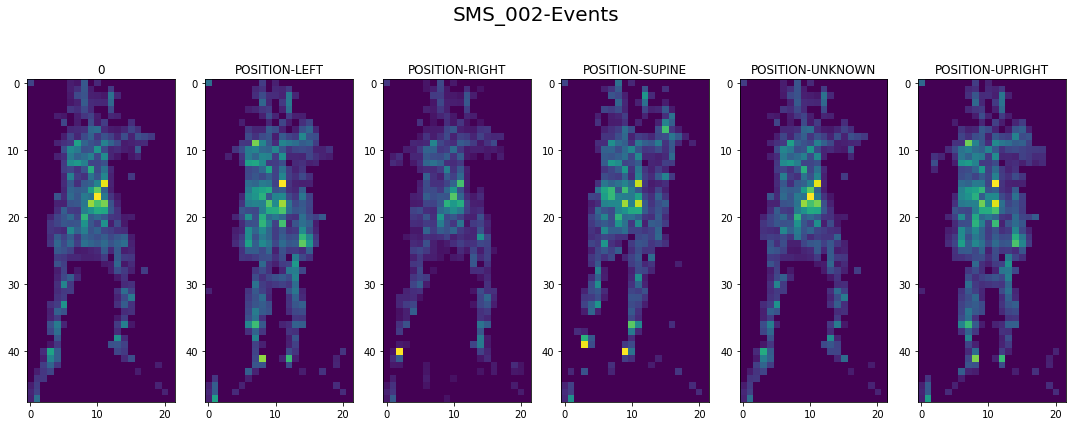

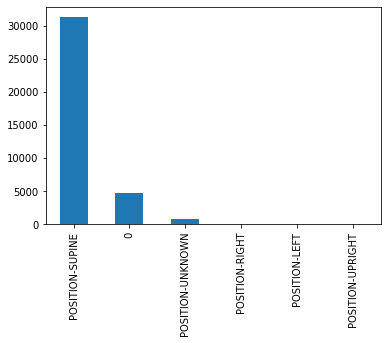

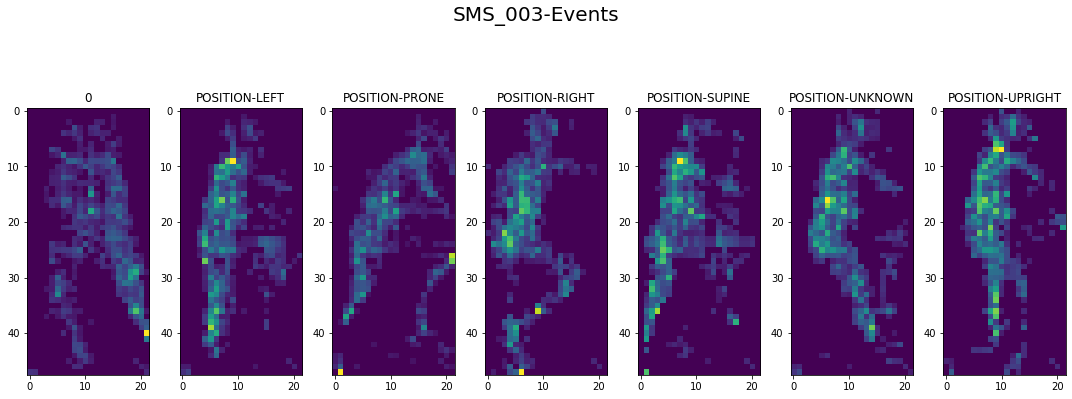

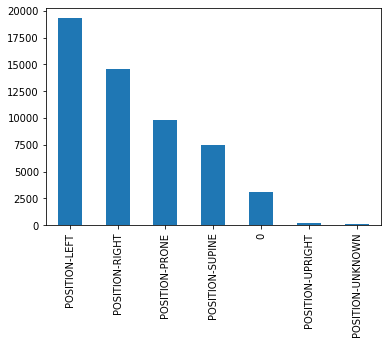

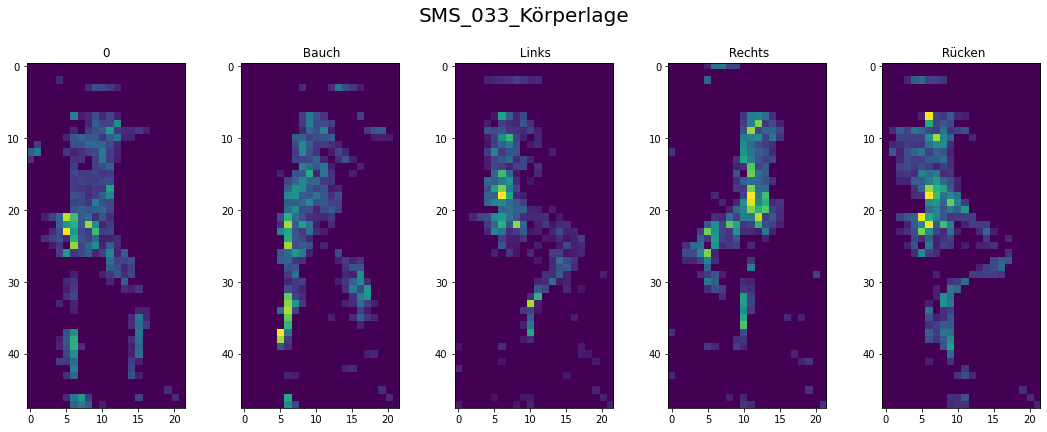

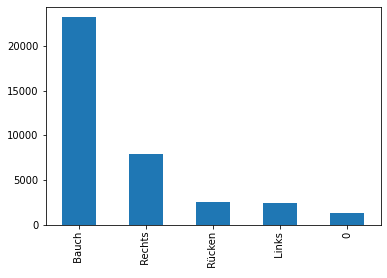

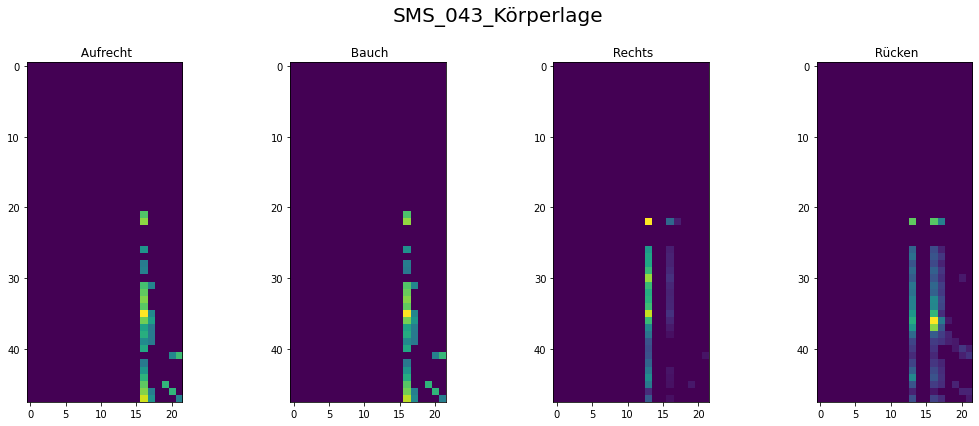

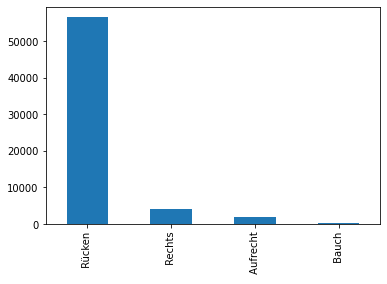

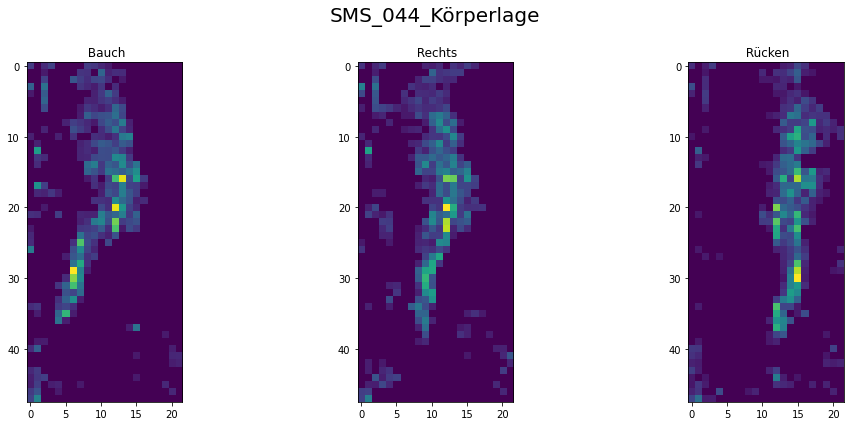

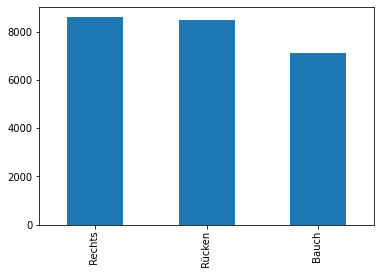

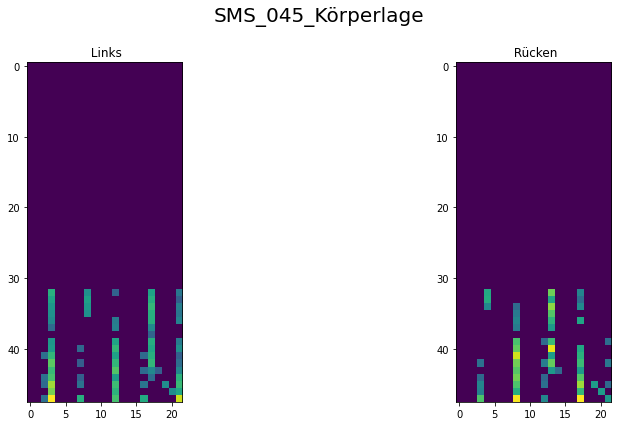

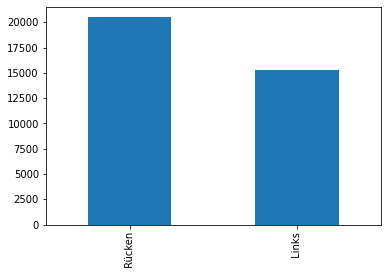

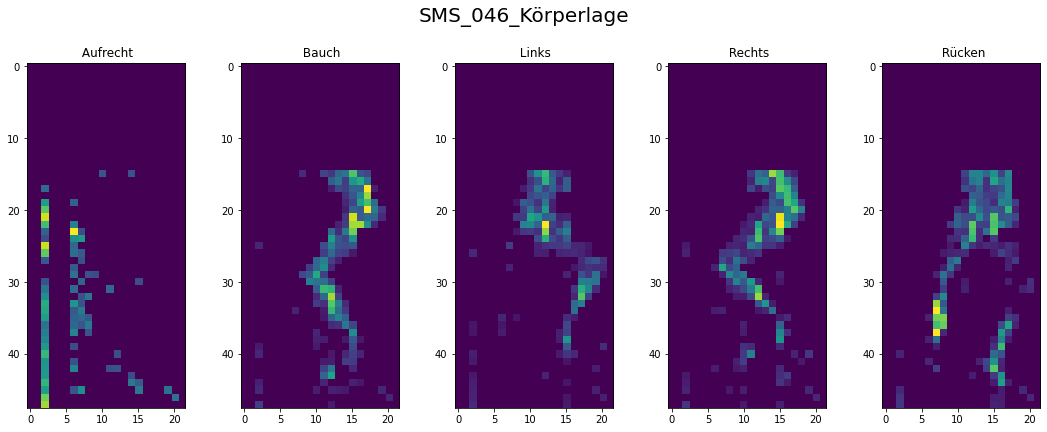

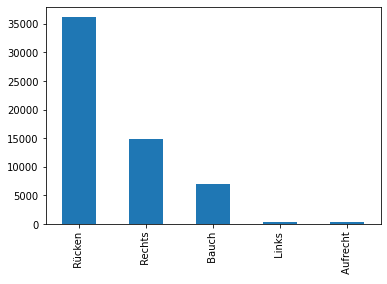

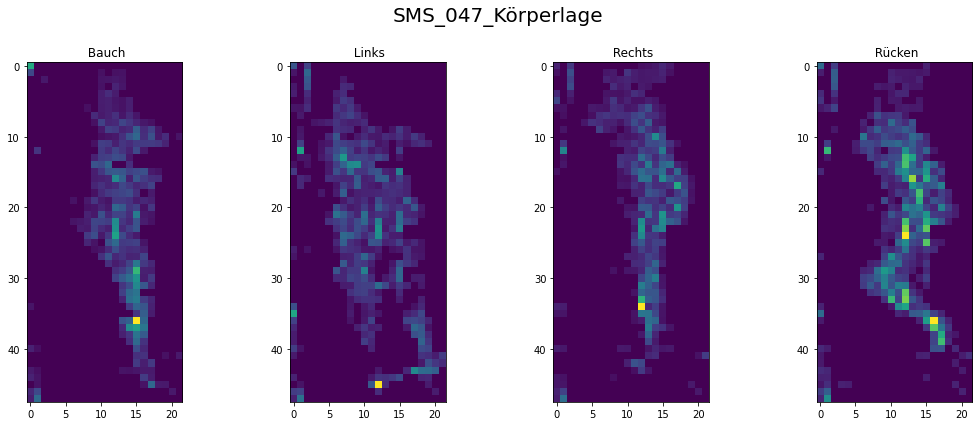

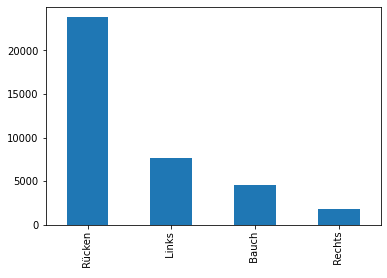

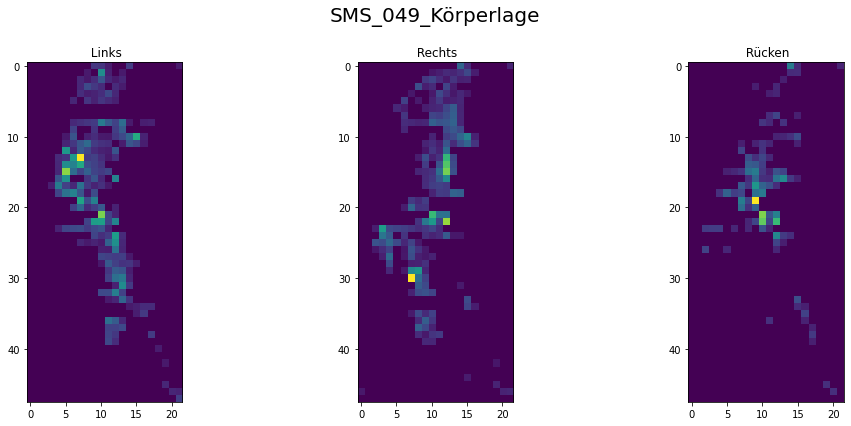

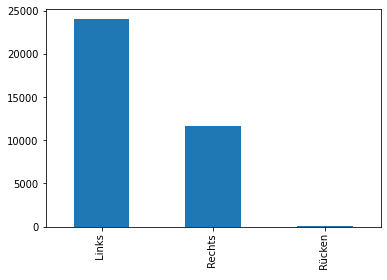

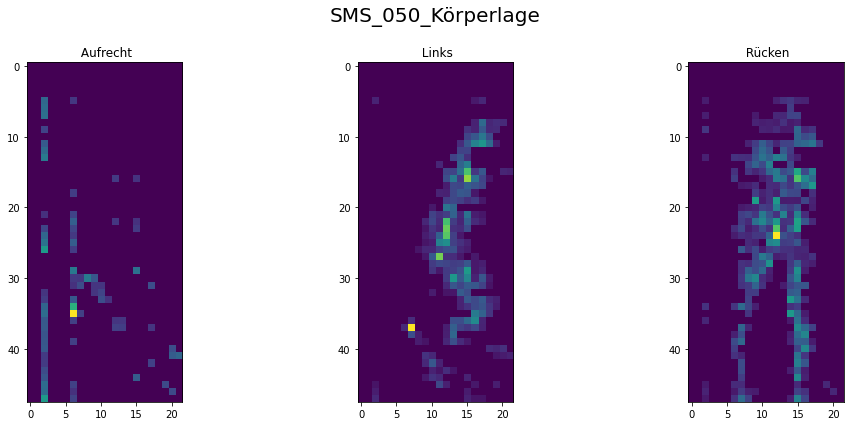

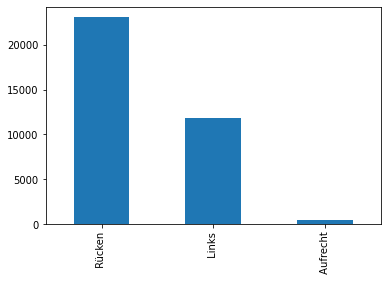

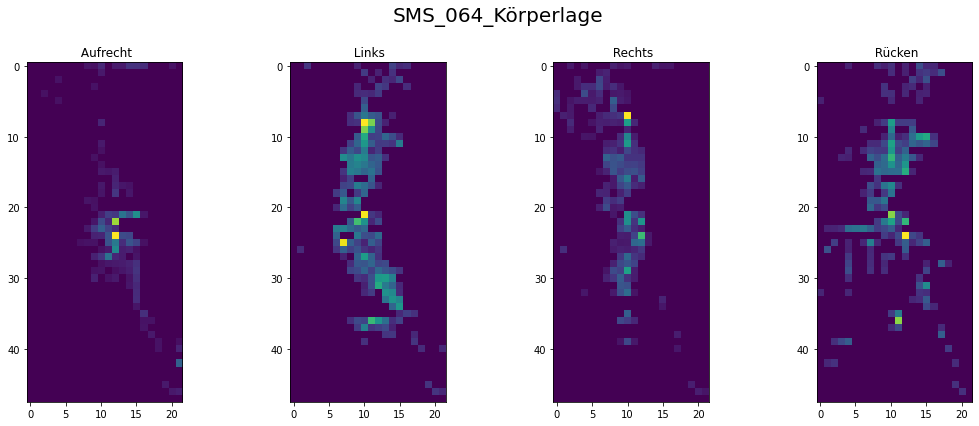

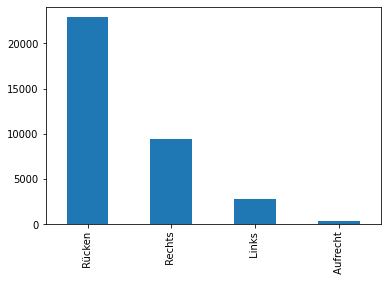

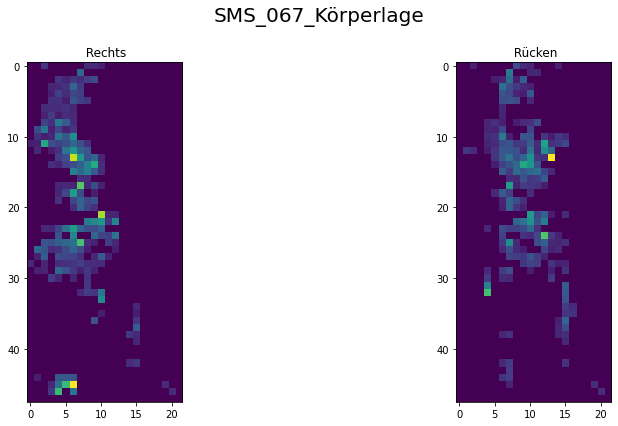

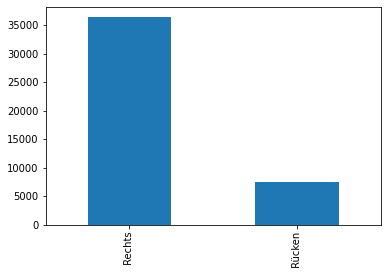

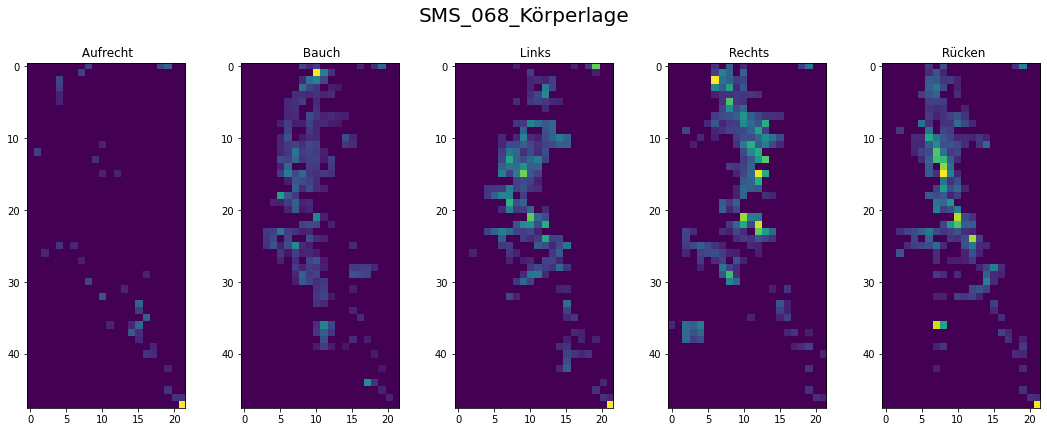

no data for SMS_070_Körperlage


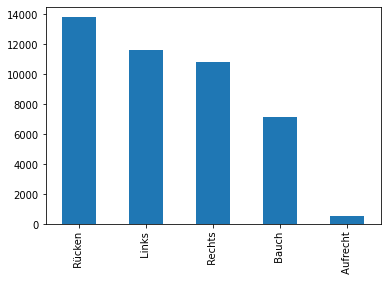

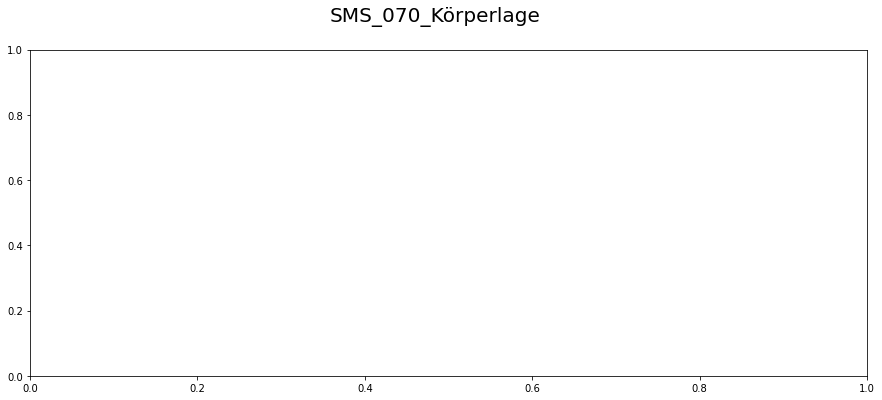

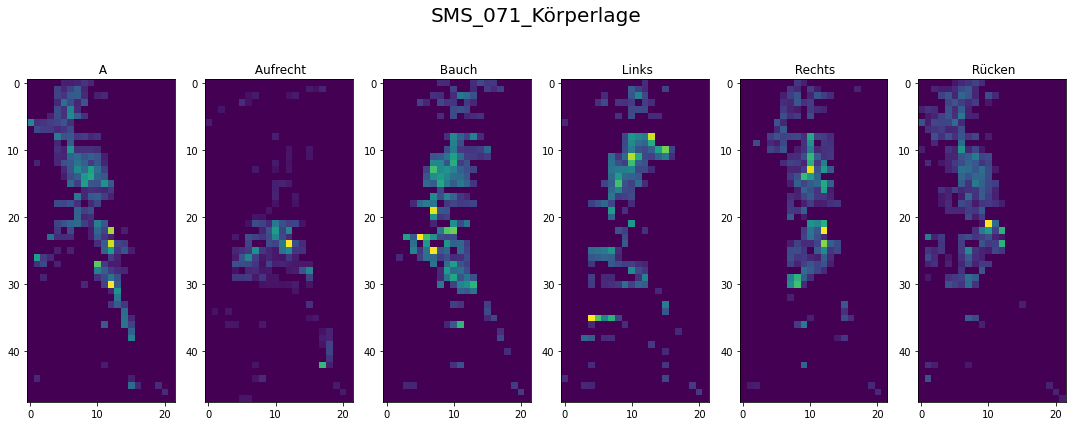

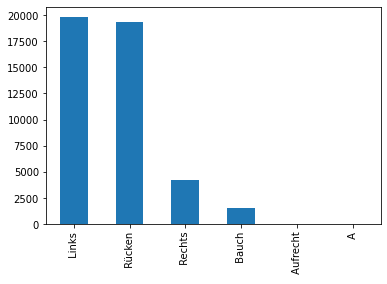

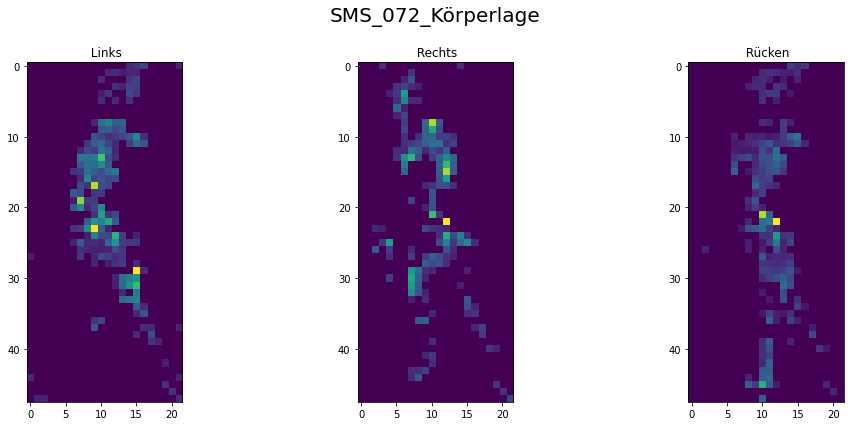

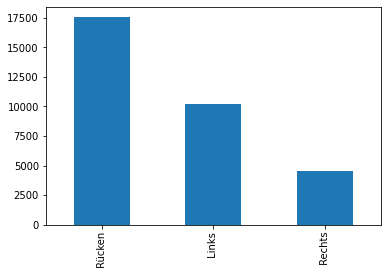

In [261]:
image_dir = os.getcwd()+'\image'
for tx, lb in zip(txt, dt):
    try:
        df_merged, df_end = get_image(tx,lb)
    except:
        print(f'no data for',tx[-22:-4])

In [60]:
def get_statistic():

    stat_dir = os.getcwd()+'\merged'
    stat_list = os.listdir(stat_dir)

    li = []

    for filename in stat_list:

        df = pd.read_csv(os.path.join(stat_dir,filename), index_col=None, header=0)
        li.append(df)

    frame = pd.concat(li, axis=0, ignore_index=True)
    frame.label = pd.np.where(frame.label == 'POSITION-UPRIGHT' ,' Aufrecht', frame.label)
    frame.label = pd.np.where(frame.label == 'POSITION-SUPINE' ,' Rücken', frame.label)
    frame.label = pd.np.where(frame.label == 'POSITION-LEFT' ,' Links', frame.label)
    frame.label = pd.np.where(frame.label == 'POSITION-RIGHT',' Rechts', frame.label)
    frame.label = pd.np.where(frame.label == 'POSITION-UNKNOWN',' A', frame.label)
    frame.label = pd.np.where(frame.label == 'POSITION-PRONE',' Bauch', frame.label)
    frame.label = pd.np.where(frame.label == '0',' Zeros', frame.label)
    frame.label.value_counts().plot.bar()
    return frame

C:\Users\phili\AppData\Local\Temp\ipykernel_23448\4127199309.py:14: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  frame.label = pd.np.where(frame.label == 'POSITION-UPRIGHT' ,' Aufrecht', frame.label)
C:\Users\phili\AppData\Local\Temp\ipykernel_23448\4127199309.py:15: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  frame.label = pd.np.where(frame.label == 'POSITION-SUPINE' ,' Rücken', frame.label)
C:\Users\phili\AppData\Local\Temp\ipykernel_23448\4127199309.py:16: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  frame.label = pd.np.where(frame.label == 'POSITION-LEFT' ,' Links', frame.label)
C:\Users\phili\AppData\Local\Temp\ipykernel_23448\4127199309.py:17: FutureWarning: The pandas.np module is deprecated and will be remove

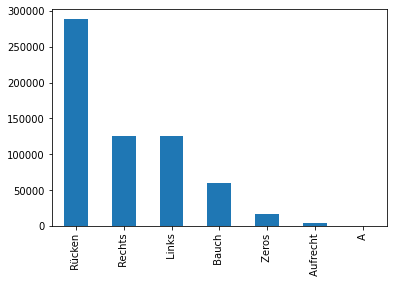

In [61]:
frame = get_statistic()

Clustering

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [115]:
def get_cluster(txt,dt,num_img):
    
    df_merged, df_end = get_label(txt,dt)
    # Correct some entry from old dataset
    df_merged.label = pd.np.where(df_merged.label == 'POSITION-UPRIGHT' ,' Aufrecht', df_merged.label)
    df_merged.label = pd.np.where(df_merged.label == 'POSITION-SUPINE' ,' Rücken', df_merged.label)
    df_merged.label = pd.np.where(df_merged.label == 'POSITION-LEFT' ,' Links', df_merged.label)
    df_merged.label = pd.np.where(df_merged.label == 'POSITION-RIGHT',' Rechts', df_merged.label)
    df_merged.label = pd.np.where(df_merged.label == 'POSITION-UNKNOWN',' A', df_merged.label)
    df_merged.label = pd.np.where(df_merged.label == 'POSITION-PRONE',' Bauch', df_merged.label)
    df_merged.label = pd.np.where(df_merged.label == 0,' Zeros', df_merged.label)
    # Bring number of sample
    counts_col = df_merged.groupby("label")["label"].transform(len)
    mask = (counts_col > int(num_img)) 
    df_merged = df_merged[mask]
    df_merged = df_merged.groupby('label').sample(n=int(num_img),random_state=2).reset_index().drop(columns=['index'])
    
    img = []
    for i in range(0, len(df_merged)):
        img.append(df_merged['pressure'].iloc[i])
    img = np.array(img)
    X_train = img
    X = X_train.reshape(-1,X_train.shape[1]*X_train.shape[2])#We will only be using X for clustering. No need of y.
    print ("The shape of X is " + str(X.shape))
    # To perform PCA we must first change the mean to 0 and variance to 1 for X using StandardScalar
    Clus_dataSet = StandardScaler().fit_transform(X) #(mean = 0 and variance = 1)
    # Make an instance of the Model
    variance = 0.98 #The higher the explained variance the more accurate the model will remain
    pca = PCA(variance)
    #fit the data according to our PCA instance
    pca.fit(Clus_dataSet)
    print("Number of components before PCA  = " + str(X.shape[1]))
    print("Number of components after PCA 0.98 = " + str(pca.n_components_)) #dimension reduced from 1056

    #Transform our data according to our PCA instance
    Clus_dataSet = pca.transform(Clus_dataSet)
    print("Dimension of our data after PCA  = " + str(Clus_dataSet.shape)) 
    #To visualise the data inversed from PCA
    approximation = pca.inverse_transform(Clus_dataSet)
    print("Dimension of our data after inverse transforming the PCA  = " + str(approximation.shape))
    #image reconstruction using the less dimensioned data
    plt.figure(figsize=(8,4));

    # #Visualize PCA 
    # labels = {
    # str(i): f"PC {i+1} ({var:.1f}%)"
    # for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    # }

    # fig = px.scatter_matrix(
    #     Clus_dataSet,
    #     labels=labels,
    #     dimensions=range(4),
    #     color=df_merged["label"]
    # )
    # fig.update_traces(diagonal_visible=False)
    # fig.show()


    n = 500 #index value, change to view different data

    # Original Image
    plt.subplot(1, 2, 1);
    plt.imshow(X[n].reshape(X_train.shape[1], X_train.shape[2]),
                cmap = plt.cm.gray,);
    plt.xlabel(str(X.shape[1])+' components', fontsize = 14)
    plt.title('Original Image', fontsize = 20);

    # 196 principal components
    plt.subplot(1, 2, 2);
    plt.imshow(approximation[n].reshape(X_train.shape[1], X_train.shape[2]),
                cmap = plt.cm.gray,);
    plt.xlabel(str(Clus_dataSet.shape[1]) +' components', fontsize = 14)
    plt.title(str(variance * 100) + '% of Variance Retained', fontsize = 20);

    y_train = df_merged['label']
    y = y_train
    print(y.unique())
    #n_clusters = number of unique value because INDEX has 10 values. Not the best value but a simple logic.
    #The value of n_init at 30 yields good results so we will use it. For confirmation us the above code.
    k_means = KMeans(init = "k-means++", n_clusters = y.nunique(), n_init = 30)
    #fit the data to our k_means model
    k_means.fit(Clus_dataSet)


    k_means_labels = k_means.labels_ #List of labels of each dataset
    print("The list of labels of the clusters are " + str(np.unique(k_means_labels)))
    G = len(np.unique(k_means_labels)) #Number of labels

    #2D matrix  for an array of indexes of the given label
    cluster_index= [[] for i in range(G)]
    for i, label in enumerate(k_means_labels,0):
        for n in range(G):
            if label == n:
                cluster_index[n].append(i)
            else:
                continue  

    # # #Visualisation for clusters = clust
    # plt.figure(figsize=(20,20));
    # clust = y.nunique() #enter label number to visualise
    # num = 100 #num of data to visualize from the cluster
    # for i in range(1,num): 
    #     plt.subplot(10, 10, i); #(Number of rows, Number of column per row, item number)
    #     plt.imshow(X[cluster_index[clust][i+1]].reshape(X_train.shape[1], X_train.shape[2]), cmap = plt.cm.binary);
        
    # plt.show()

    Y_clust = [[] for i in range(G)]
    for n in range(G):
        Y_clust[n] = y[cluster_index[n]] #Y_clust[0] contains array of "correct" category from y_train for the cluster_index[0]
        assert(len(Y_clust[n]) == len(cluster_index[n])) #dimension confirmation

    #counts the number of each category in each cluster
    def counter(cluster):
        unique, counts = np.unique(cluster, return_counts=True)
        label_index = dict(zip(unique, counts))
        return label_index

    label_count= [[] for i in range(G)]
    for n in range(G):
        label_count[n] = counter(Y_clust[n])

    label_count[1] #Number of items of a certain category in cluster 1
    #A function to plot a bar graph for visualising the number of items of certain category in a cluster
    def plotter(label_dict):
        plt.bar(range(len(label_dict)), list(label_dict.values()), align='center')
        a = []
        for i in [*label_dict]: a.append([i])
        plt.xticks(range(len(label_dict)), list(a), rotation=45, rotation_mode='anchor')
    #Bar graph with the number of items of different categories clustered in it
    plt.figure(figsize=(20,20))
    for i in range (1,(y.nunique())+1):
        plt.subplot(3, 2, i)
        plotter(label_count[i-1]) 
        plt.title("Cluster" + str(i-1))

    return Clus_dataSet

Transfer Learning as Feature Extraction

In [173]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from keras.layers import Concatenate

In [ ]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [131]:
img_size_target = 224
img_input = Input(shape=(img_size_target, img_size_target, 1))
img_conc = Concatenate()([img_input, img_input, img_input])  
model = VGG16(input_tensor=img_conc)

In [ ]:
img = df_merged.pressure[0]
reshaped_img = img.reshape(48, 22, 1)
img_conc = Concatenate()([reshaped_img, reshaped_img, reshaped_img])  

In [160]:
img = df_merged.pressure[0]
reshaped_img = img.reshape(48, 22, 1)

In [161]:
img_conc = Concatenate()([reshaped_img, reshaped_img, reshaped_img])  

In [156]:
# model = VGG16(weights="imagenet", include_top=False,
# 	input_shape=img_conc)

In [ ]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [ ]:

img_size_target = 224
img_input = Input(shape=(img_size_target, img_size_target, 1))
img_conc = Concatenate()([img_input, img_input, img_input])  
model = VGG16(input_tensor=img_conc)

Data Augmentation

In [133]:
# example of zoom image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

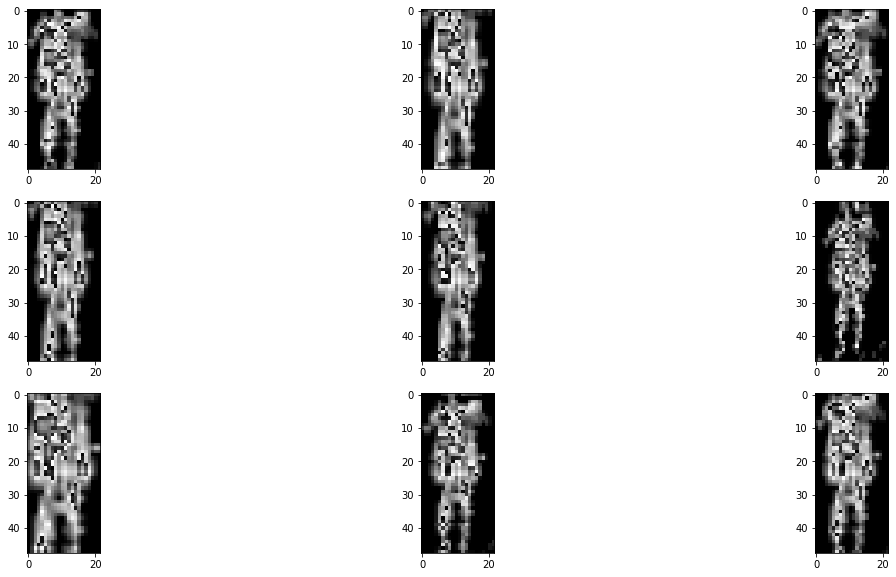

<Figure size 1440x720 with 0 Axes>

In [174]:
img = df_merged.pressure[0]
reshaped_img = img.reshape(48, 22, 1)
img_conc = Concatenate()([reshaped_img, reshaped_img, reshaped_img])  
data = img_conc
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(zoom_range=[0.5,1.0])
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
plt.figure(figsize=(20,10))
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
pyplot.figure(figsize=(20,10));
# show the figure
pyplot.show()

Shift left and right

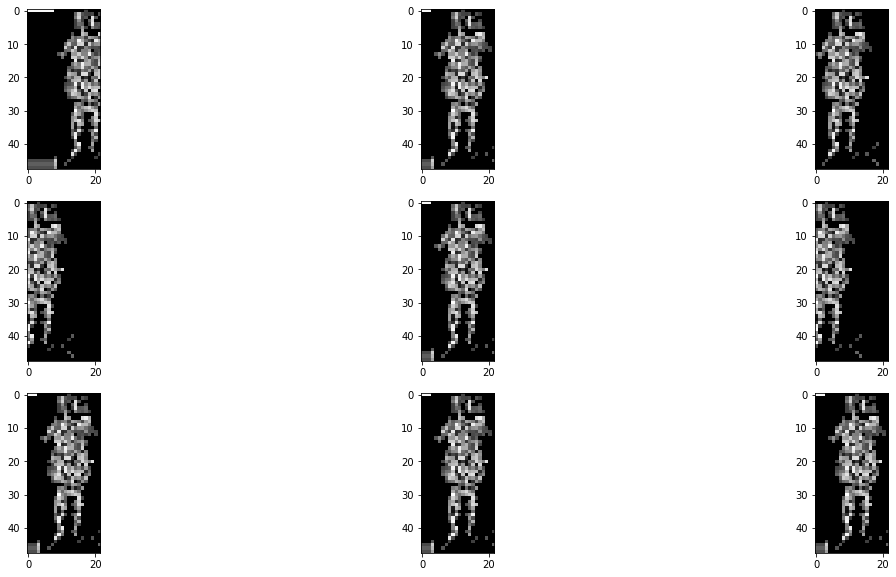

In [175]:
data = img_conc
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=[2,7])
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
plt.figure(figsize=(20,10))
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

The shape of X is (600, 1056)
Number of components before PCA  = 1056
Number of components after PCA 0.98 = 38
Dimension of our data after PCA  = (600, 38)
Dimension of our data after inverse transforming the PCA  = (600, 1056)
[' A' ' Rücken' ' Zeros']
The list of labels of the clusters are [0 1 2]


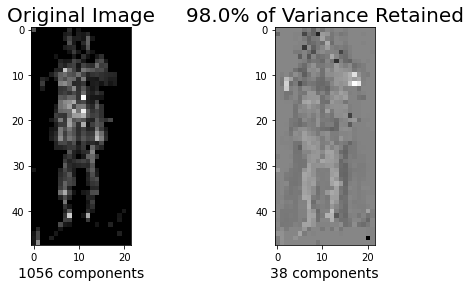

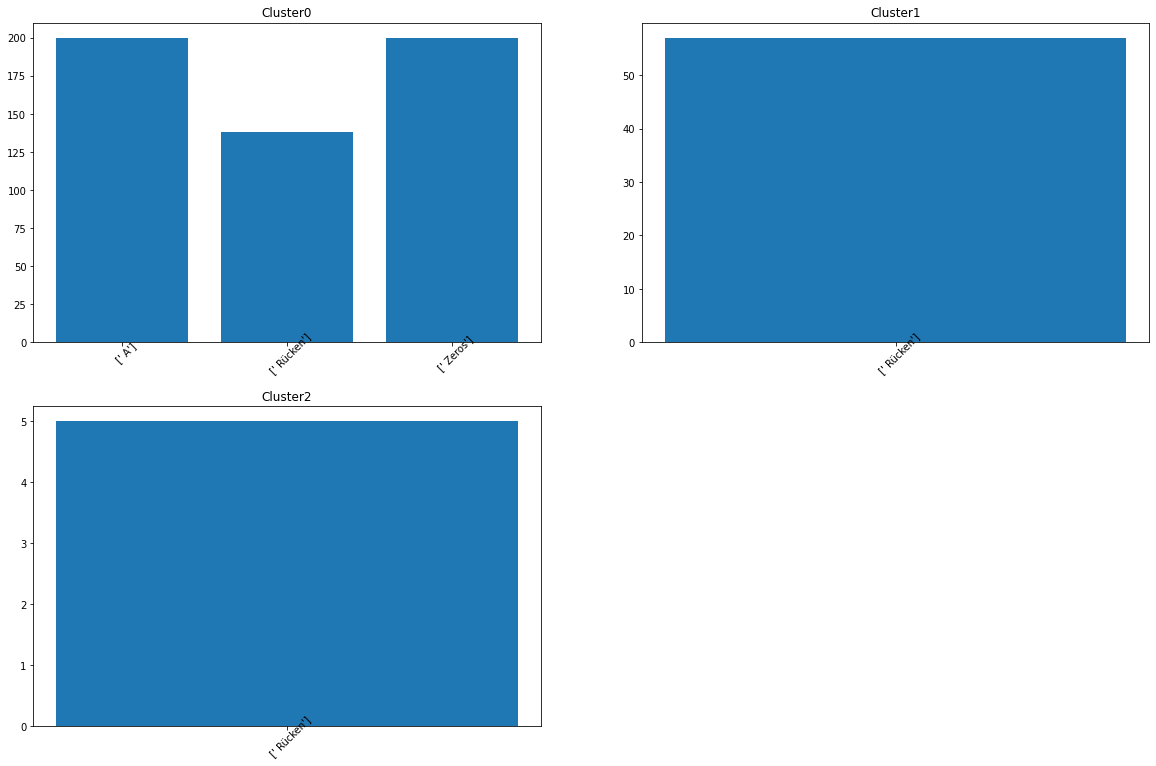

In [116]:
test = get_cluster(txt[0],dt[0],200)

Check similarities Images
https://betterprogramming.pub/how-to-measure-image-similarities-in-python-12f1cb2b7281


In [88]:
import image_similarity_measures
from image_similarity_measures.quality_metrics import rmse, ssim, sre

In [92]:
check_ssim = ssim(df_merged.pressure[0],df_merged.pressure[1])

In [94]:
check_ssim

0.9972259264865861

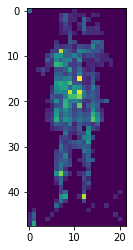

In [91]:
plt.imshow(df_merged.pressure[0])

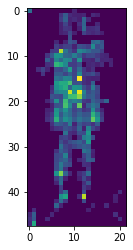

In [178]:
plt.imshow(df_merged.pressure[1])

In [97]:
df_merged

,time,pressure,end,label,frequency
0,2021-08-08 20:58:01.140,"[[248.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",2021-08-08 20:58:01.941,0,0 days 00:00:00.801000
1,2021-08-08 20:58:01.941,"[[248.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",2021-08-08 20:58:02.442,0,0 days 00:00:00.501000
2,2021-08-08 20:58:02.442,"[[249.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",2021-08-08 20:58:02.943,0,0 days 00:00:00.501000
3,2021-08-08 20:58:02.943,"[[248.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",2021-08-08 20:58:03.445,0,0 days 00:00:00.502000
4,2021-08-08 20:58:03.445,"[[248.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",2021-08-08 20:58:03.946,0,0 days 00:00:00.501000
...,...,...,...,...,...
36897,2021-08-09 04:07:56.699,"[[217.0, 0.0, 0.0, 0.0, 0.0, 0.0, 72.0, 66.0, ...",2021-08-09 04:07:57.401,POSITION-RIGHT,0 days 00:00:00.702000
36898,2021-08-09 04:07:57.401,"[[222.0, 0.0, 0.0, 0.0, 0.0, 0.0, 72.0, 67.0, ...",2021-08-09 04:07:58.103,POSITION-RIGHT,0 days 00:00:00.702000
36899,2021-08-09 04:07:58.103,"[[222.0, 0.0, 0.0, 0.0, 0.0, 0.0, 72.0, 67.0, ...",2021-08-09 04:07:58.805,POSITION-RIGHT,0 days 00:00:00.702000
36900,2021-08-09 04:07:58.805,"[[223.0, 0.0, 0.0, 0.0, 0.0, 0.0, 72.0, 67.0, ...",2021-08-09 04:07:59.507,POSITION-RIGHT,0 days 00:00:00.702000


The shape of X is (600, 1056)
Number of components before PCA  = 1056
Number of components after PCA 0.98 = 38
Dimension of our data after PCA  = (600, 38)
Dimension of our data after inverse transforming the PCA  = (600, 1056)


[' A' ' Rücken' ' Zeros']
The list of labels of the clusters are [0 1 2]


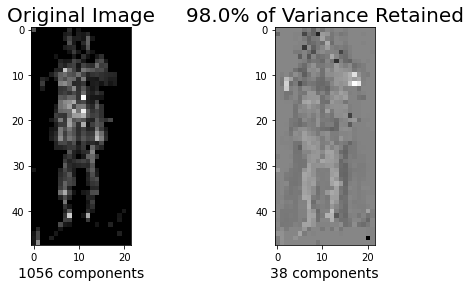

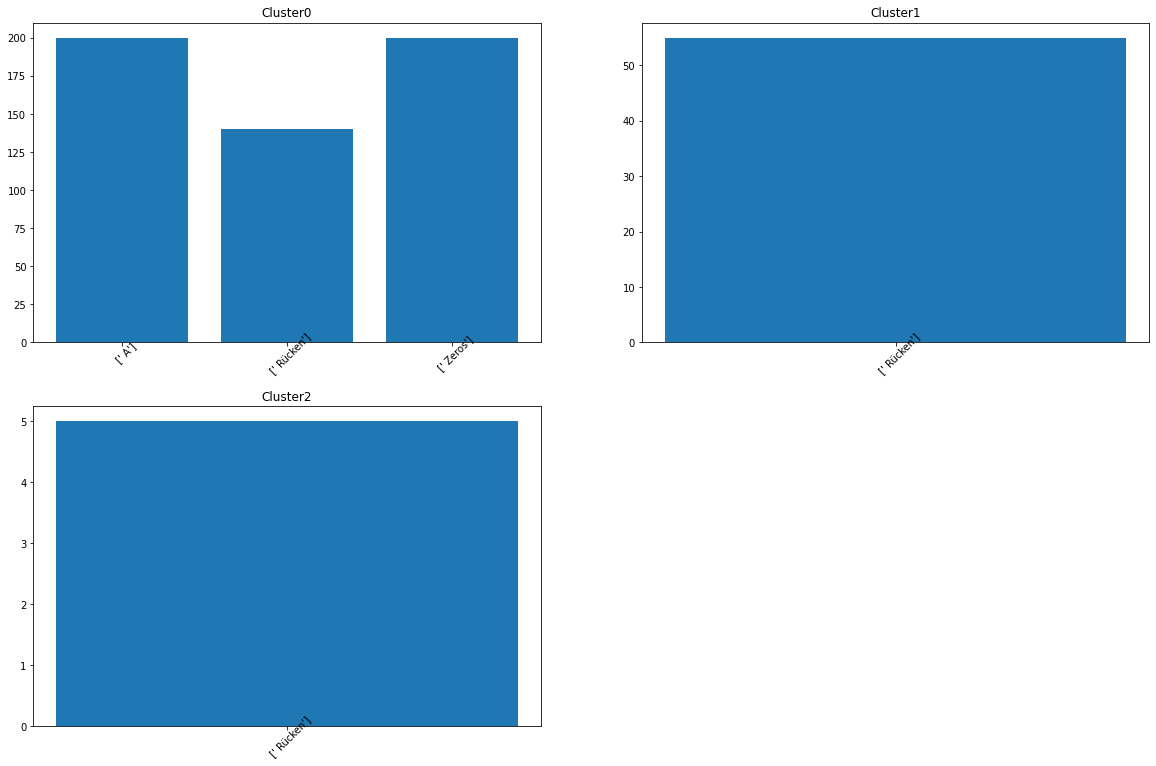

In [112]:
get_cluster(txt[0],dt[0],200)

The shape of X is (600, 1056)
Number of components before PCA  = 1056
Number of components after PCA 0.98 = 38
Dimension of our data after PCA  = (600, 38)
Dimension of our data after inverse transforming the PCA  = (600, 1056)
[' A' ' Rücken' ' Zeros']
The list of labels of the clusters are [0 1 2]


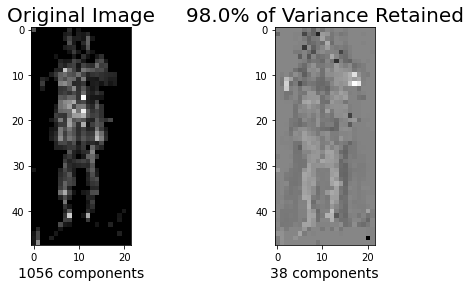

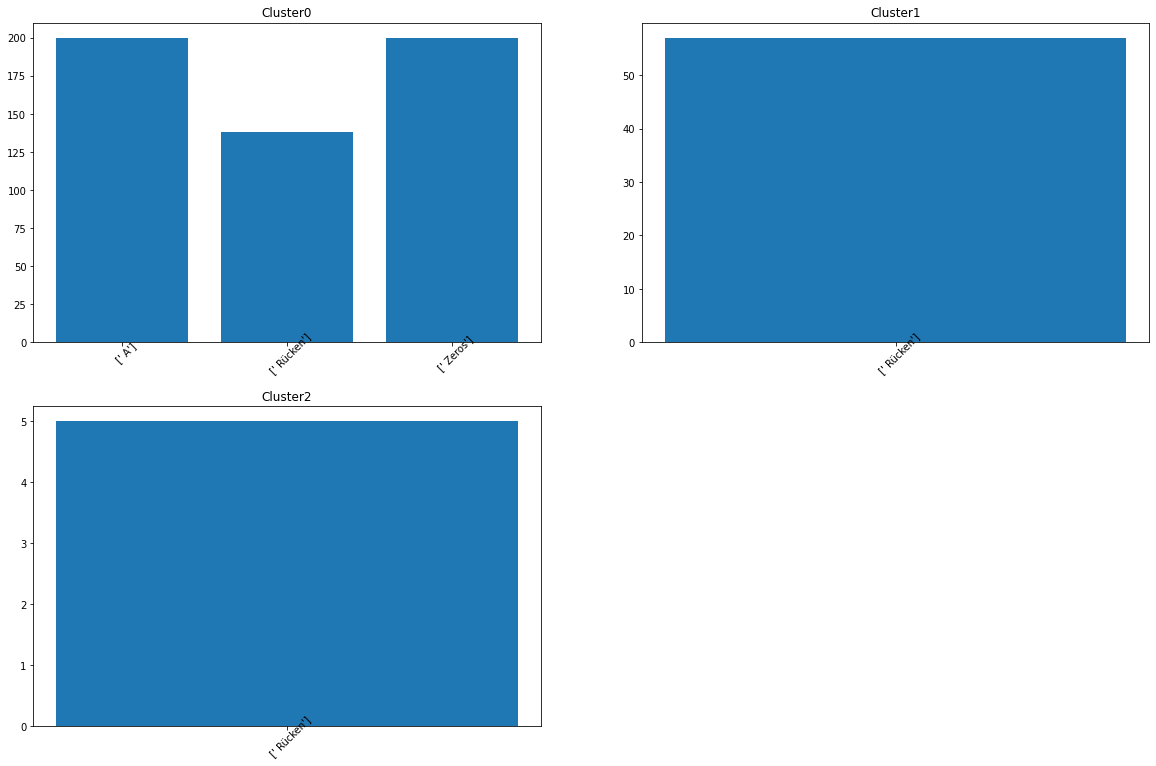

In [106]:
get_cluster(txt[0],dt[0],200)

The shape of X is (36902, 1056)
Number of components before PCA  = 1056
Number of components after PCA 0.98 = 168
Dimension of our data after PCA  = (36902, 168)
Dimension of our data after inverse transforming the PCA  = (36902, 1056)
[' Zeros' ' Aufrecht' ' Rücken' ' A' ' Links' ' Rechts']
The list of labels of the clusters are [0 1 2 3 4 5]


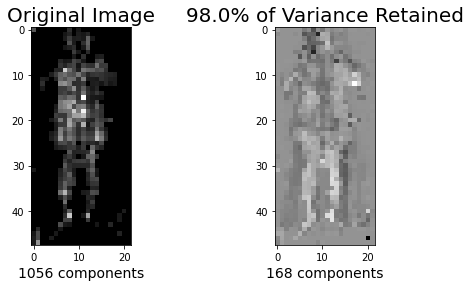

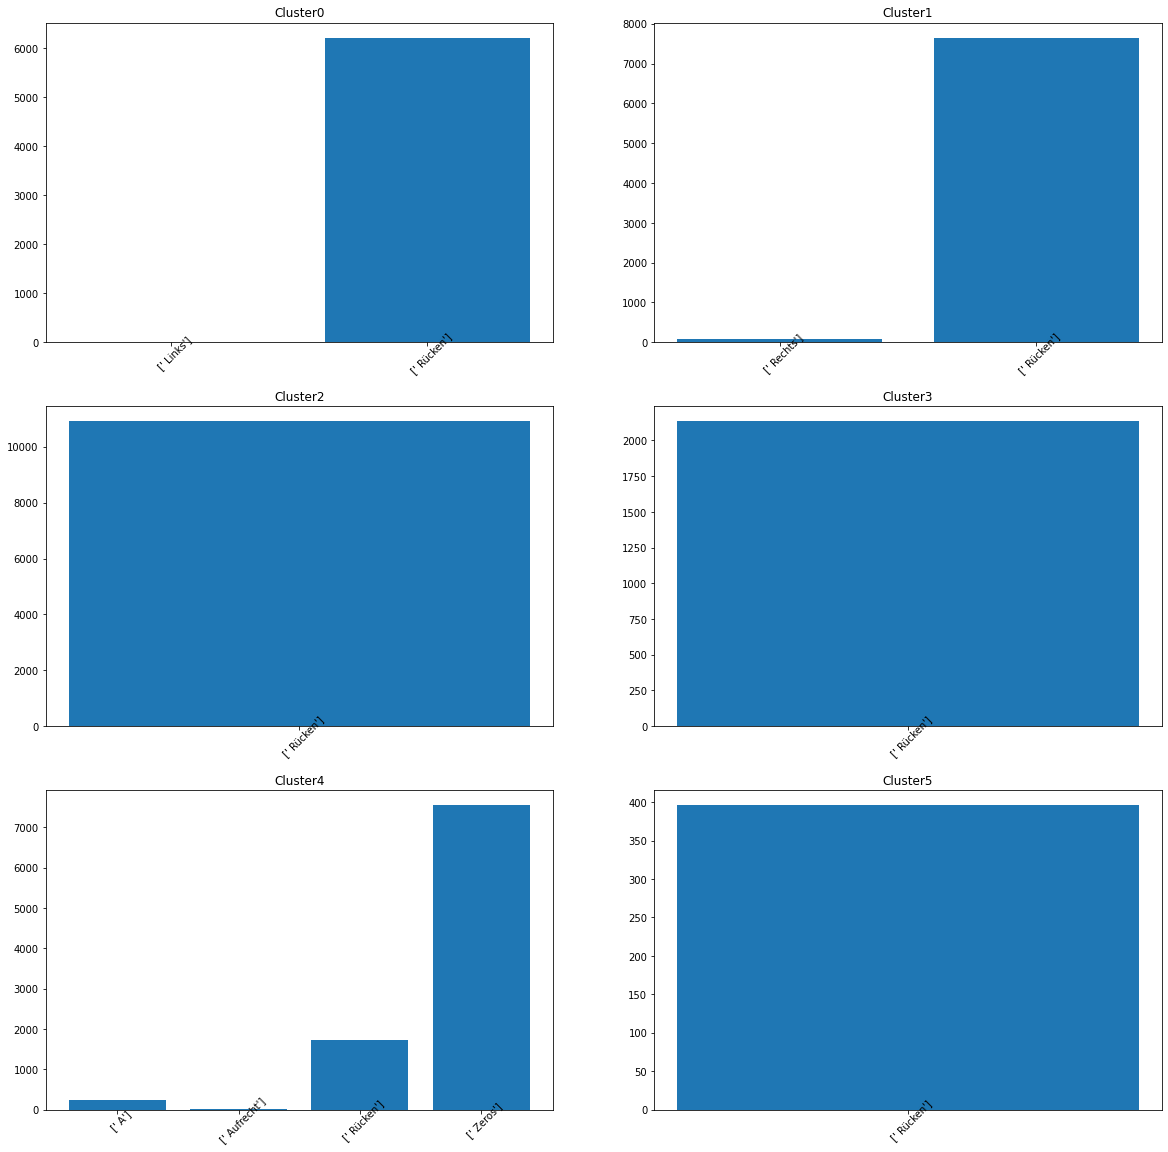

In [68]:
get_cluster(txt[0],dt[0])

The shape of X is (62758, 1056)
Number of components before PCA  = 1056
Number of components after PCA 0.98 = 82
Dimension of our data after PCA  = (62758, 82)
Dimension of our data after inverse transforming the PCA  = (62758, 1056)
[' Rücken' ' Rechts' ' Aufrecht' ' Bauch']
The list of labels of the clusters are [0 1 2 3]


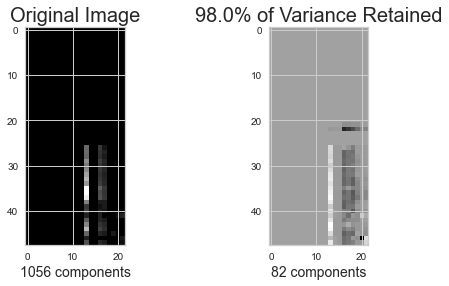

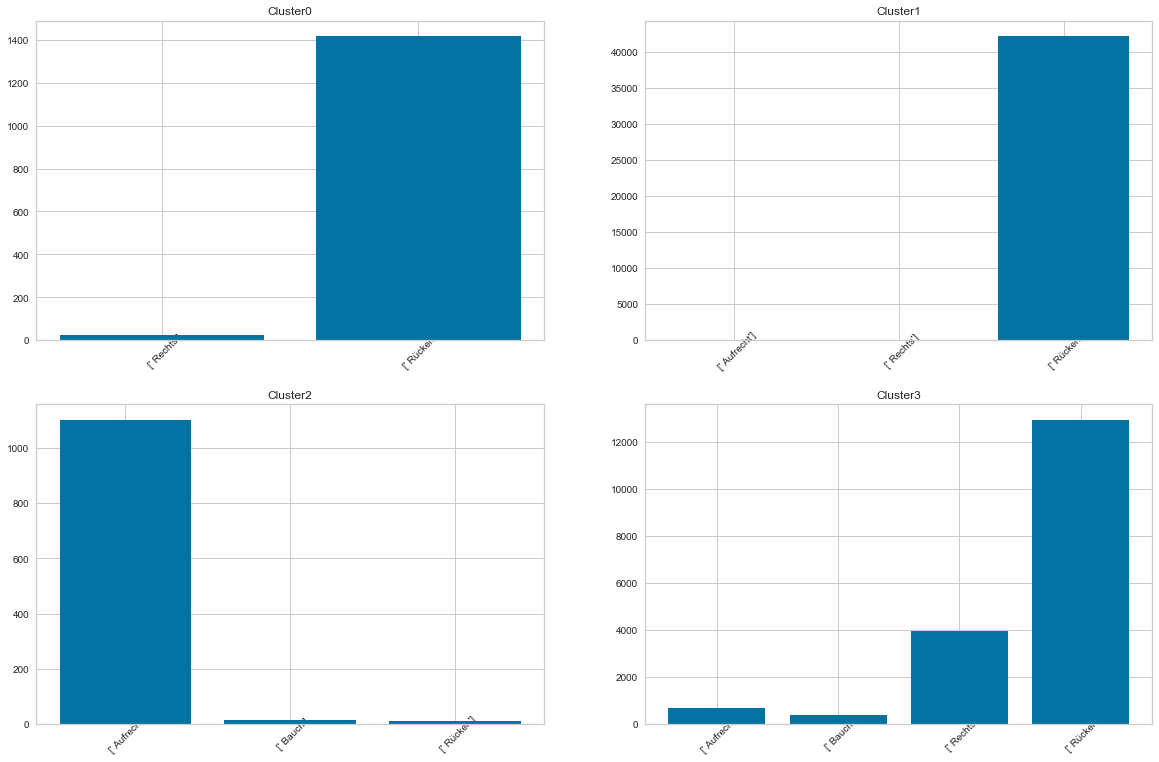

In [500]:
get_cluster(txt[3],dt[3])

In [507]:
txt[4]

'c:\\Users\\phili\\techlabs\\eth_sms\\labels\\SMS_044_Körperlage.txt'

The shape of X is (24244, 1056)
Number of components before PCA  = 1056
Number of components after PCA 0.98 = 160
Dimension of our data after PCA  = (24244, 160)
Dimension of our data after inverse transforming the PCA  = (24244, 1056)
[' Rücken' ' Bauch' ' Rechts']
The list of labels of the clusters are [0 1 2]


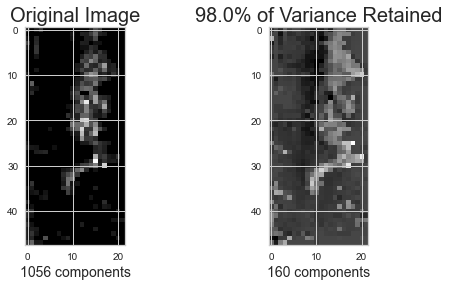

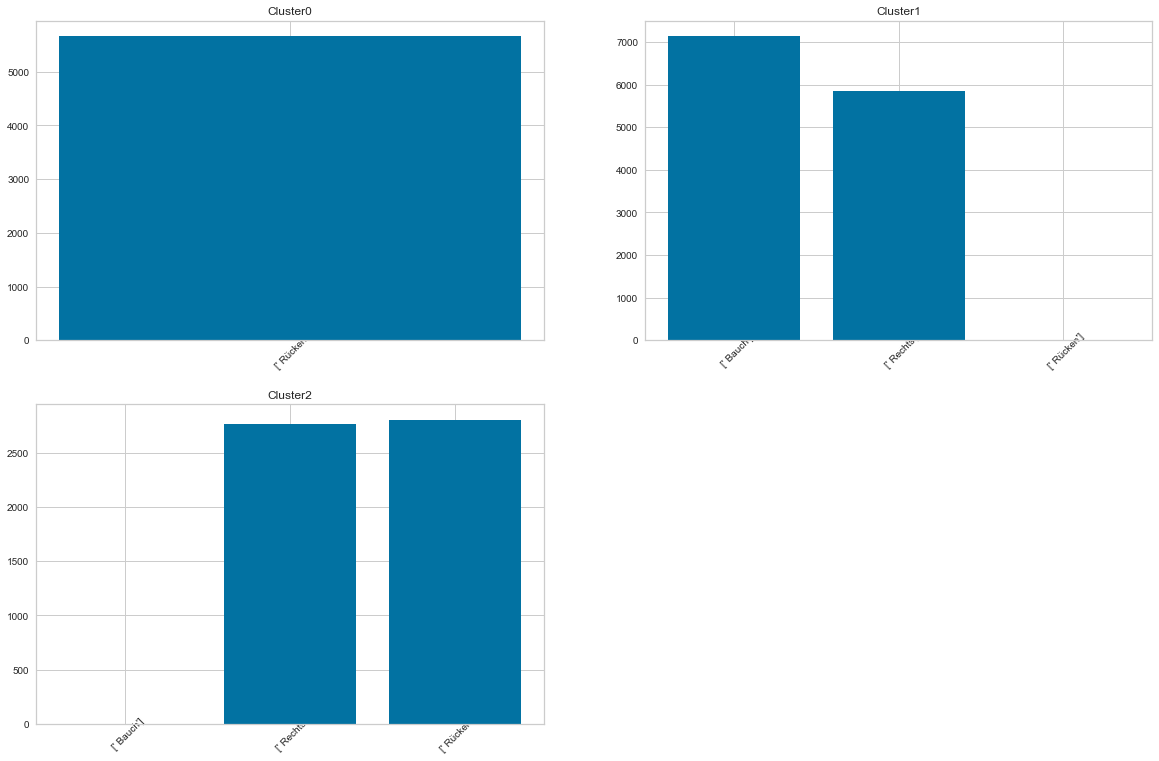

In [499]:
get_cluster(txt[4],dt[4])

In [508]:
txt[5]

'c:\\Users\\phili\\techlabs\\eth_sms\\labels\\SMS_045_Körperlage.txt'

The shape of X is (35713, 1056)
Number of components before PCA  = 1056
Number of components after PCA 0.98 = 210
Dimension of our data after PCA  = (35713, 210)
Dimension of our data after inverse transforming the PCA  = (35713, 1056)
[' Links' ' Rücken']
The list of labels of the clusters are [0 1]


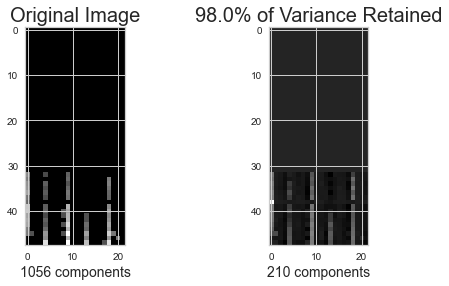

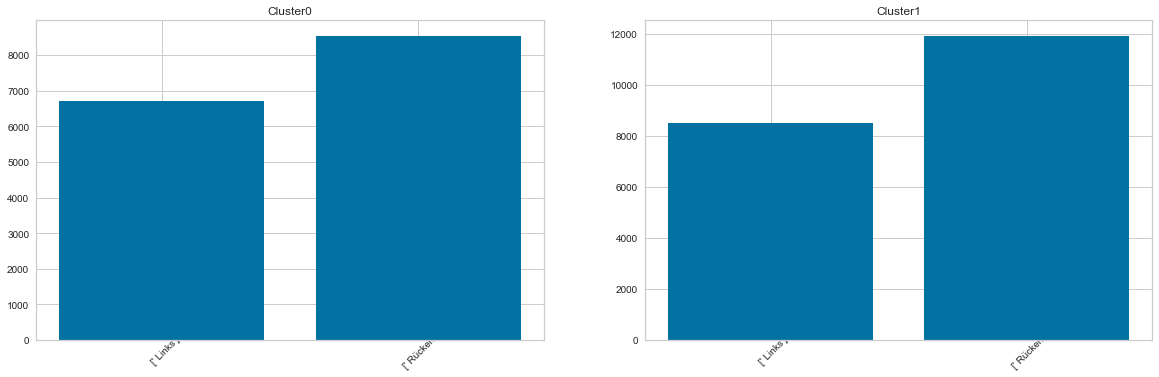

In [498]:
get_cluster(txt[5],dt[5])

In [509]:
txt[6]

'c:\\Users\\phili\\techlabs\\eth_sms\\labels\\SMS_046_Körperlage.txt'

The shape of X is (58756, 1056)
Number of components before PCA  = 1056
Number of components after PCA 0.98 = 186
Dimension of our data after PCA  = (58756, 186)
Dimension of our data after inverse transforming the PCA  = (58756, 1056)
[' Rücken' ' Links' ' Rechts' ' Aufrecht' ' Bauch']
The list of labels of the clusters are [0 1 2 3 4]


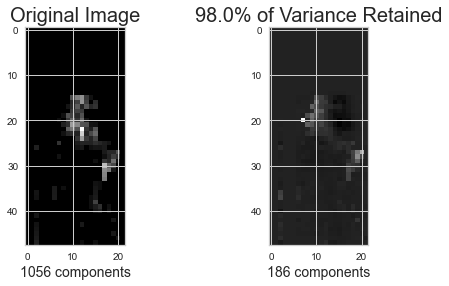

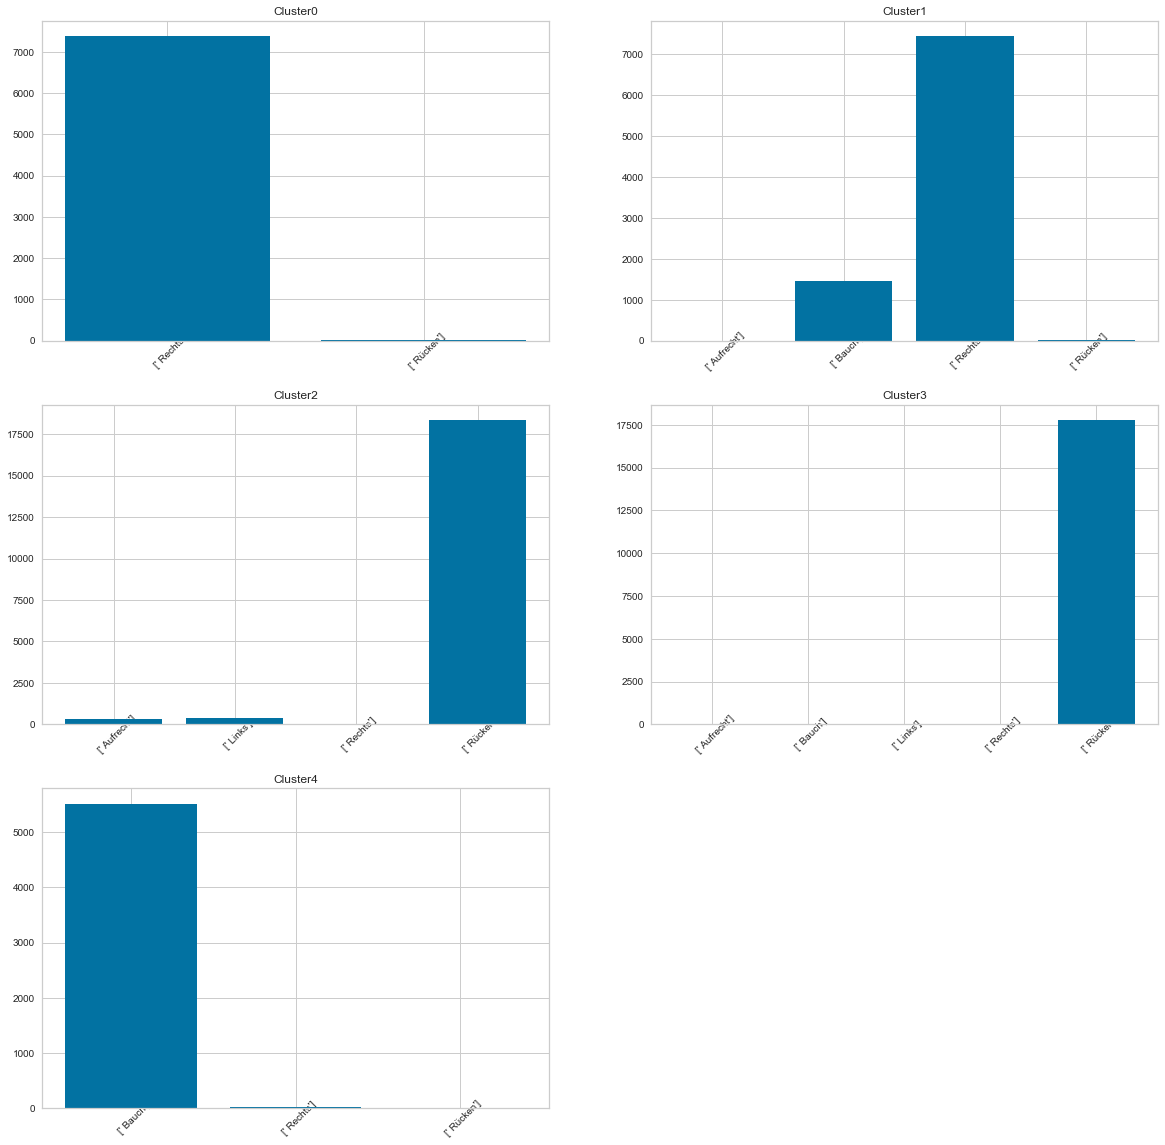

In [497]:
get_cluster(txt[6],dt[6])

In [510]:
txt[7]

'c:\\Users\\phili\\techlabs\\eth_sms\\labels\\SMS_047_Körperlage.txt'

The shape of X is (37768, 1056)
Number of components before PCA  = 1056
Number of components after PCA 0.98 = 179
Dimension of our data after PCA  = (37768, 179)
Dimension of our data after inverse transforming the PCA  = (37768, 1056)
[' Rechts' ' Rücken' ' Links' ' Bauch']
The list of labels of the clusters are [0 1 2 3]


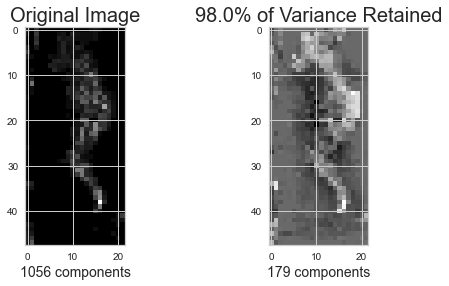

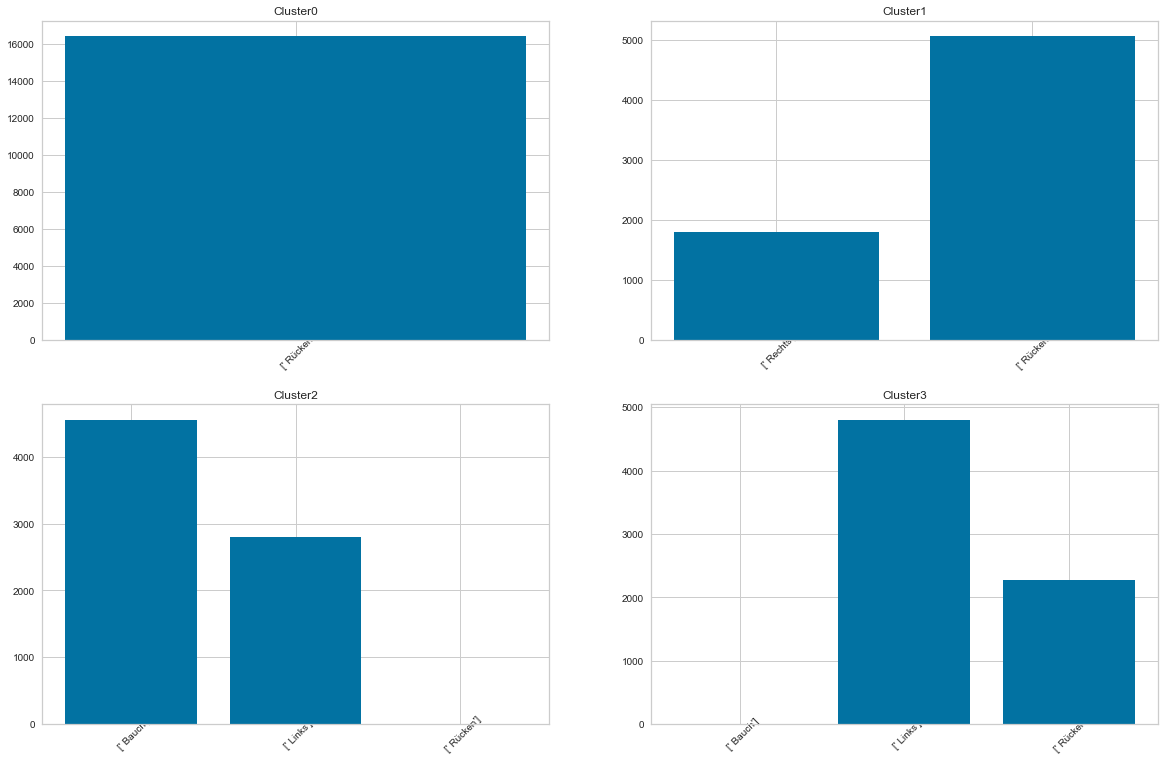

In [496]:
get_cluster(txt[7],dt[7])

In [511]:
txt[8]

'c:\\Users\\phili\\techlabs\\eth_sms\\labels\\SMS_049_Körperlage.txt'

The shape of X is (35612, 1056)
Number of components before PCA  = 1056
Number of components after PCA 0.98 = 209
Dimension of our data after PCA  = (35612, 209)
Dimension of our data after inverse transforming the PCA  = (35612, 1056)
[' Rechts' ' Rücken' ' Links']
The list of labels of the clusters are [0 1 2]


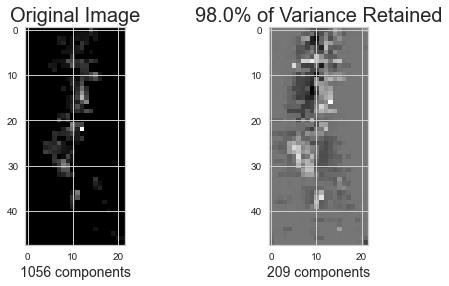

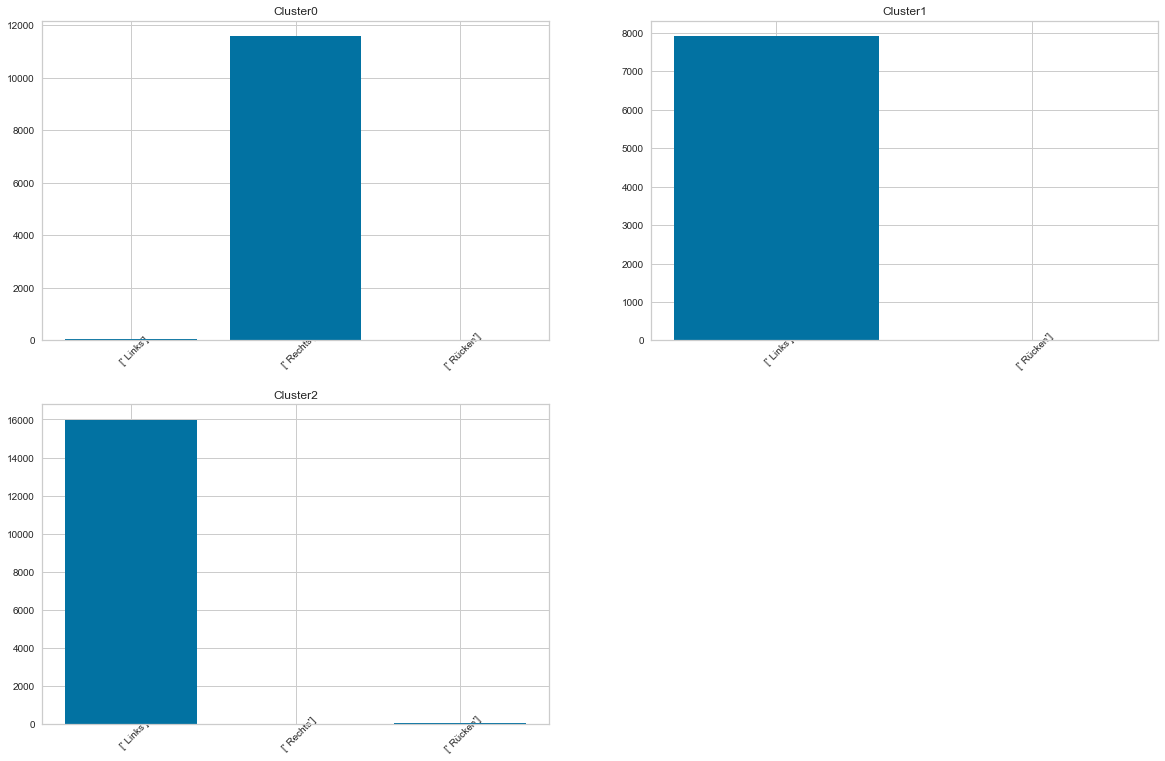

In [492]:
get_cluster(txt[8],dt[8])

In [512]:
txt[9]

'c:\\Users\\phili\\techlabs\\eth_sms\\labels\\SMS_050_Körperlage.txt'

The shape of X is (35287, 1056)
Number of components before PCA  = 1056
Number of components after PCA 0.98 = 248
Dimension of our data after PCA  = (35287, 248)
Dimension of our data after inverse transforming the PCA  = (35287, 1056)
[' Rücken' ' Links' ' Aufrecht']
The list of labels of the clusters are [0 1 2]


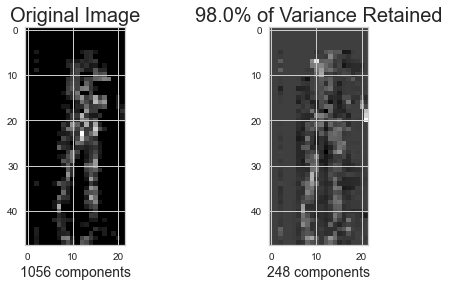

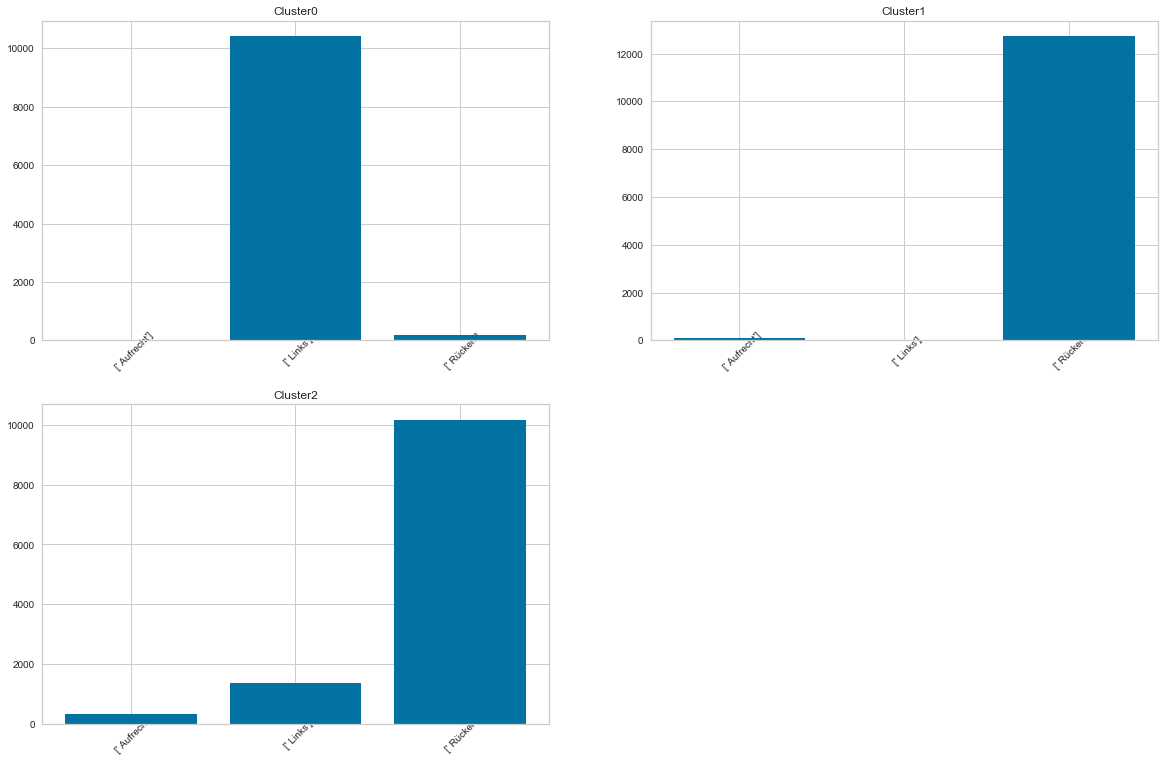

In [491]:
get_cluster(txt[9],dt[9])

In [513]:
txt[10]

'c:\\Users\\phili\\techlabs\\eth_sms\\labels\\SMS_064_Körperlage.txt'

The shape of X is (35413, 1056)
Number of components before PCA  = 1056
Number of components after PCA 0.98 = 263
Dimension of our data after PCA  = (35413, 263)
Dimension of our data after inverse transforming the PCA  = (35413, 1056)
[' Rechts' ' Links' ' Aufrecht' ' Rücken']
The list of labels of the clusters are [0 1 2 3]


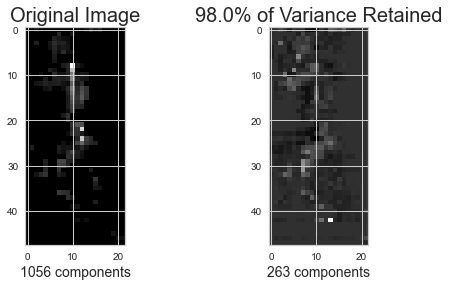

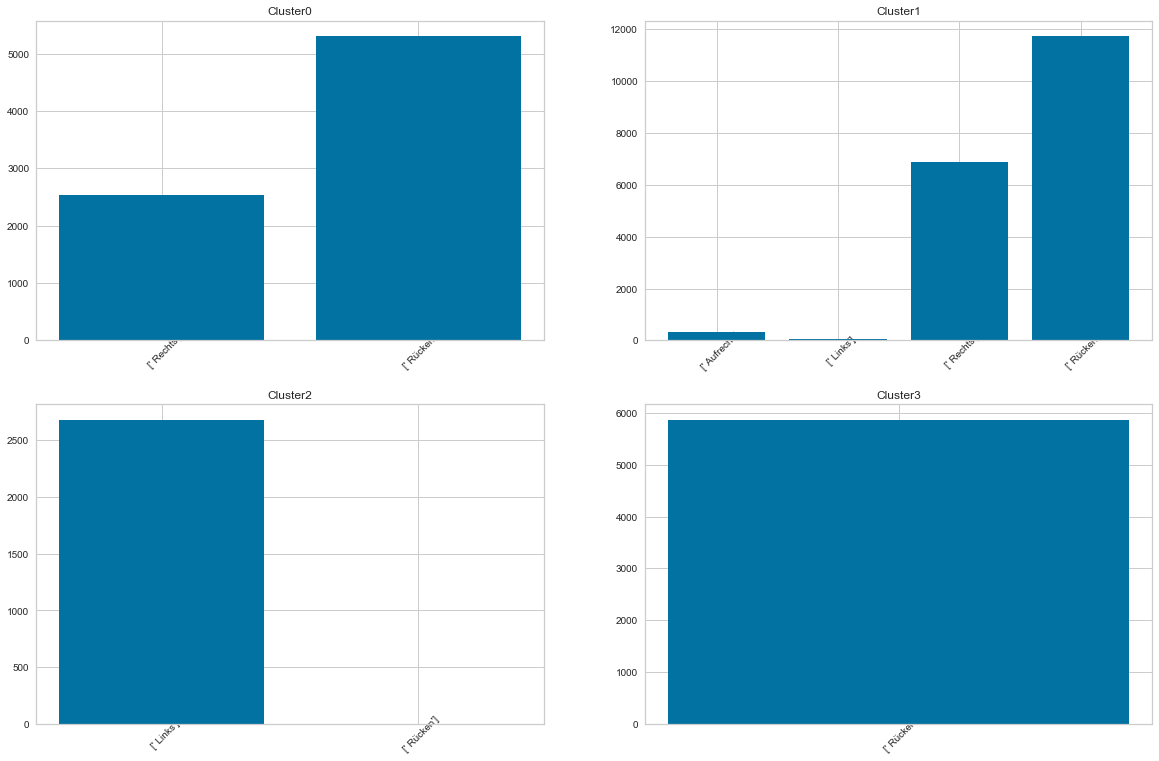

In [490]:
get_cluster(txt[10],dt[10])

In [514]:
txt[11]

'c:\\Users\\phili\\techlabs\\eth_sms\\labels\\SMS_067_Körperlage.txt'

The shape of X is (43944, 1056)
Number of components before PCA  = 1056
Number of components after PCA 0.98 = 254
Dimension of our data after PCA  = (43944, 254)
Dimension of our data after inverse transforming the PCA  = (43944, 1056)
[' Rechts' ' Rücken']
The list of labels of the clusters are [0 1]


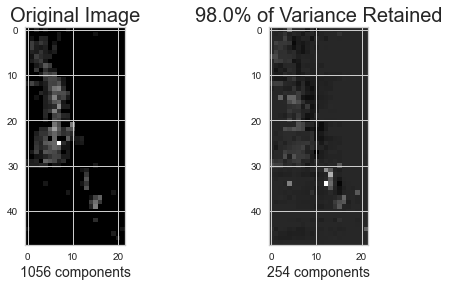

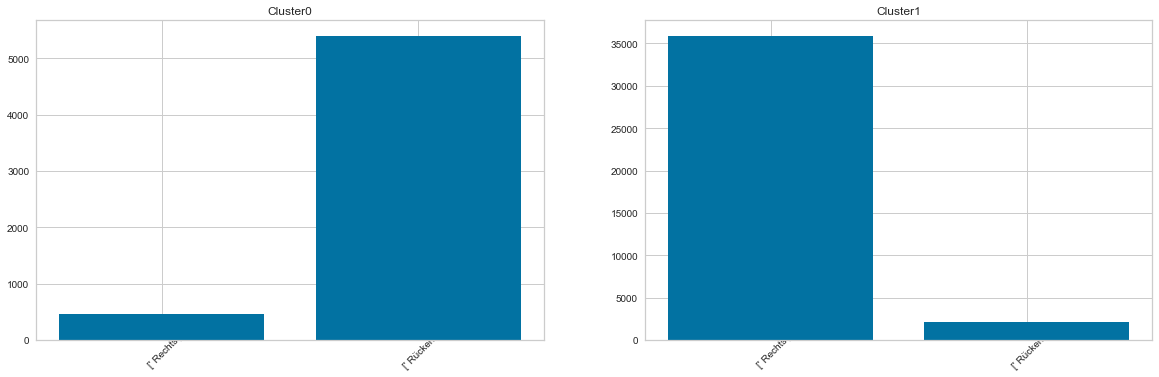

In [489]:
get_cluster(txt[11],dt[11])

In [515]:
txt[12]

'c:\\Users\\phili\\techlabs\\eth_sms\\labels\\SMS_068_Körperlage.txt'

The shape of X is (43833, 1056)
Number of components before PCA  = 1056
Number of components after PCA 0.98 = 208
Dimension of our data after PCA  = (43833, 208)
Dimension of our data after inverse transforming the PCA  = (43833, 1056)
[' Links' ' Rechts' ' Bauch' ' Rücken' ' Aufrecht']
The list of labels of the clusters are [0 1 2 3 4]


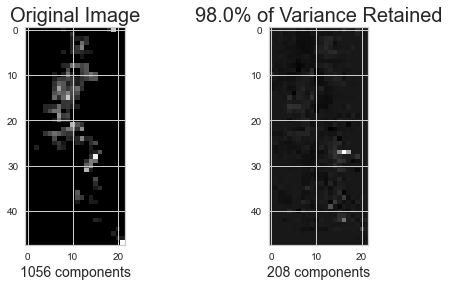

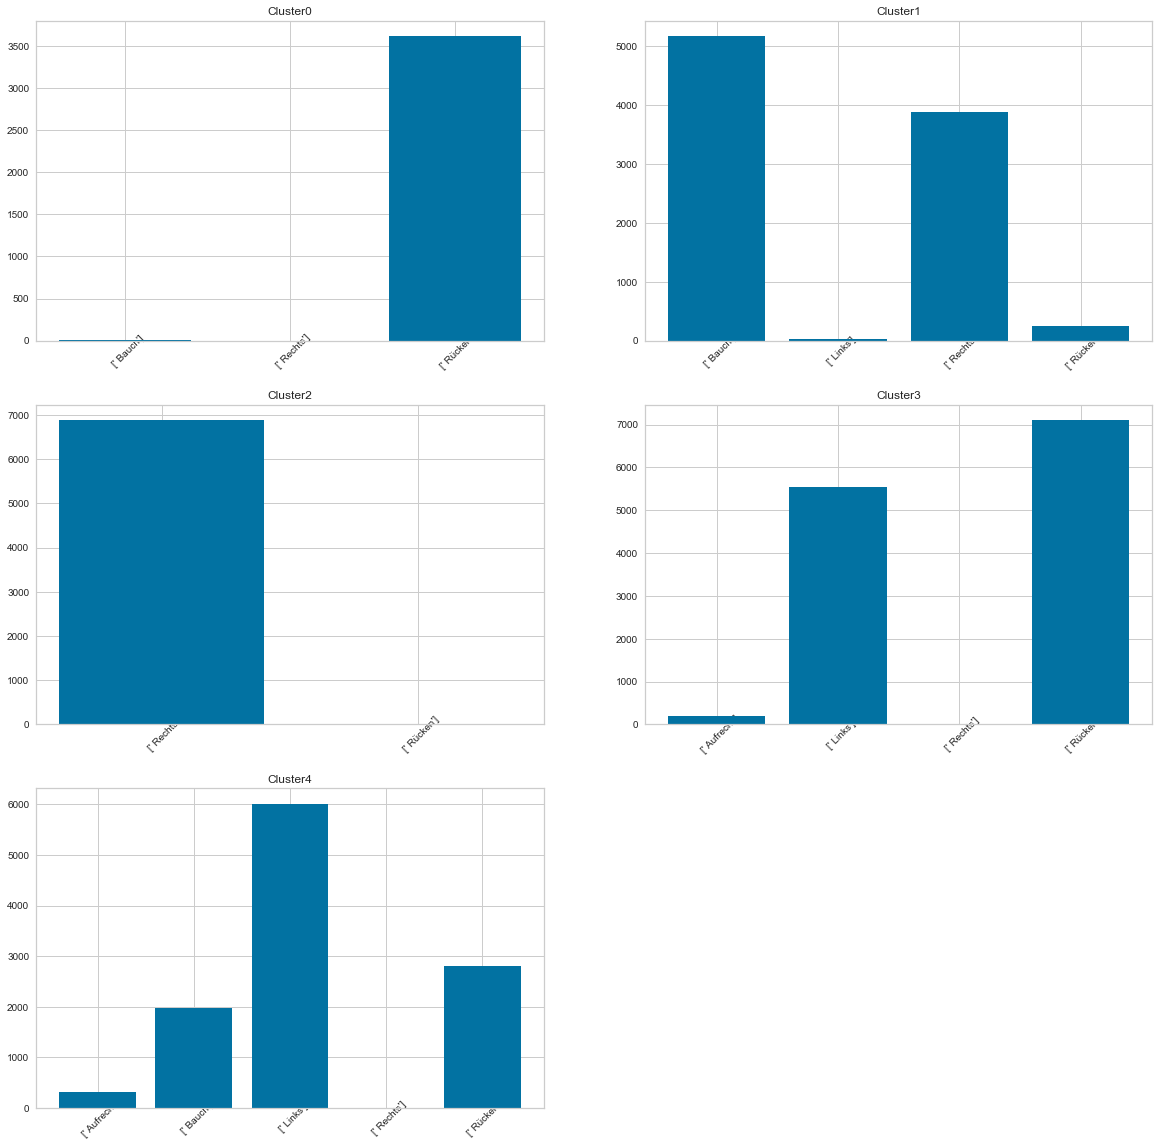

In [488]:
get_cluster(txt[12],dt[12])

In [516]:
txt[14]

'c:\\Users\\phili\\techlabs\\eth_sms\\labels\\SMS_071_Körperlage.txt'

The shape of X is (44942, 1056)
Number of components before PCA  = 1056
Number of components after PCA 0.98 = 369
Dimension of our data after PCA  = (44942, 369)
Dimension of our data after inverse transforming the PCA  = (44942, 1056)
[' Rücken' ' Rechts' ' Aufrecht' ' Links' ' Bauch' ' A']
The list of labels of the clusters are [0 1 2 3 4 5]


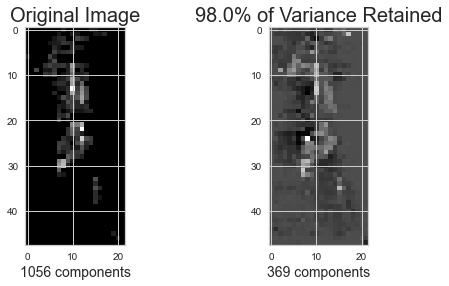

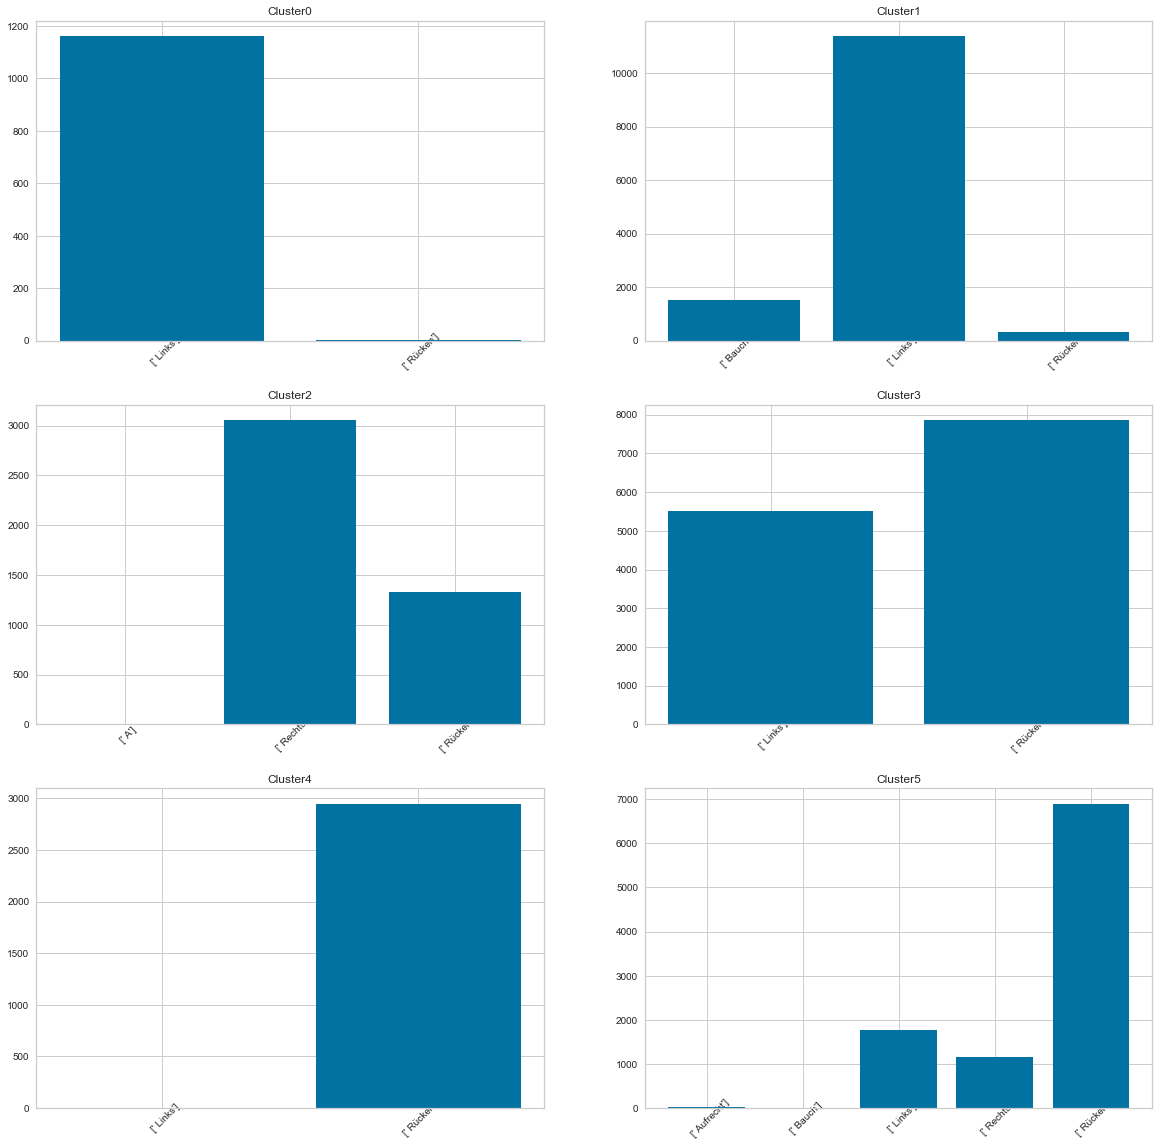

In [503]:
get_cluster(txt[14],dt[14])

In [517]:
txt[15]

'c:\\Users\\phili\\techlabs\\eth_sms\\labels\\SMS_072_Körperlage.txt'

The shape of X is (32323, 1056)
Number of components before PCA  = 1056
Number of components after PCA 0.98 = 210
Dimension of our data after PCA  = (32323, 210)
Dimension of our data after inverse transforming the PCA  = (32323, 1056)
[' Links' ' Rücken' ' Rechts']
The list of labels of the clusters are [0 1 2]


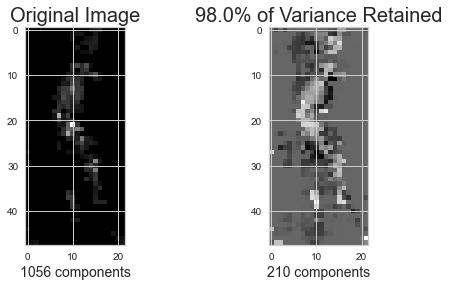

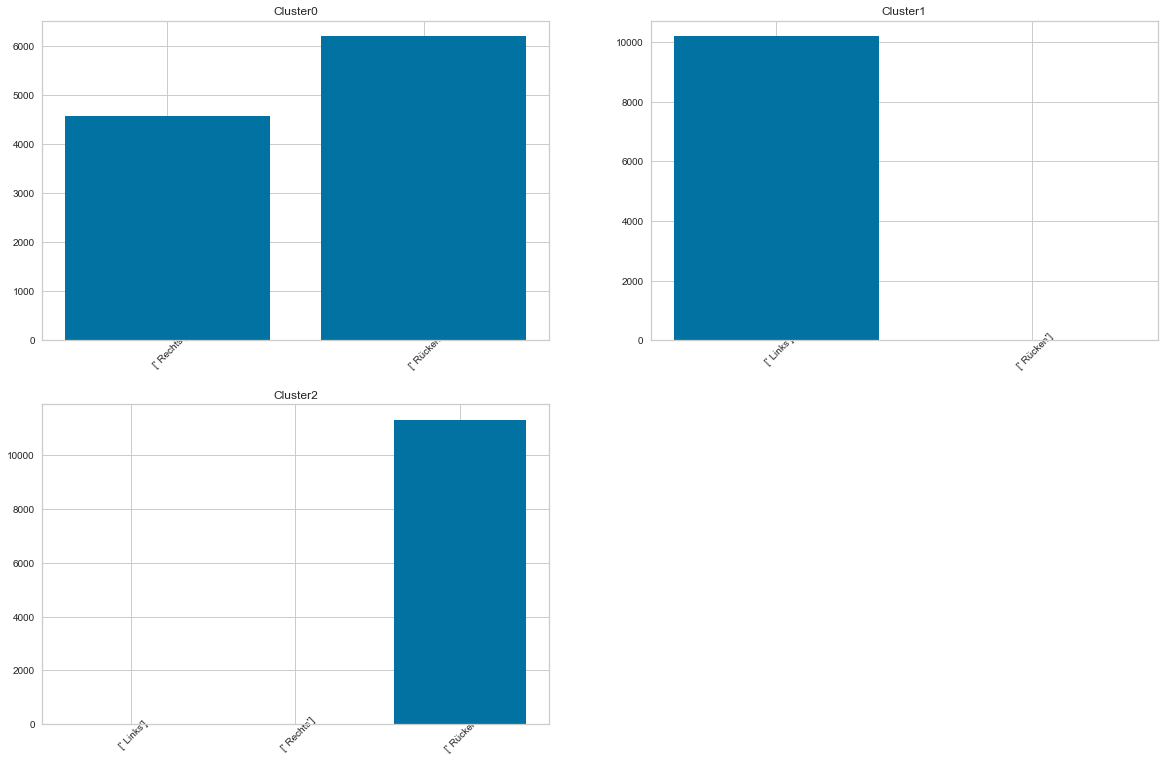

In [504]:
get_cluster(txt[15],dt[15])

Clustering

In [445]:
df_merged, df_end = get_label(txt[12],dt[12])

In [446]:
df_merged.label.unique()

array([' Links', ' Rechts', ' Bauch', ' Rücken', ' Aufrecht'],
      dtype=object)

In [447]:
img = []
for i in range(0, len(df)):
    img.append(df_merged['pressure'].iloc[i])

In [448]:
img = np.array(img)

In [449]:
X_train = img
X = X_train.reshape(-1,X_train.shape[1]*X_train.shape[2])#We will only be using X for clustering. No need of y.
print ("The shape of X is " + str(X.shape))

The shape of X is (8239, 1056)


PCA

In [450]:
# To perform PCA we must first change the mean to 0 and variance to 1 for X using StandardScalar
Clus_dataSet = StandardScaler().fit_transform(X) #(mean = 0 and variance = 1)

In [451]:
from sklearn.decomposition import PCA
# Make an instance of the Model
variance = 0.98 #The higher the explained variance the more accurate the model will remain
pca = PCA(variance)

In [452]:
#fit the data according to our PCA instance
pca.fit(Clus_dataSet)

PCA(n_components=0.98)

In [453]:
print("Number of components before PCA  = " + str(X.shape[1]))
print("Number of components after PCA 0.98 = " + str(pca.n_components_)) #dimension reduced from 1056

Number of components before PCA  = 1056
Number of components after PCA 0.98 = 168


In [ ]:
# #Transform our data according to our PCA instance
# Clus_dataSet = pca.transform(Clus_dataSet)
# print("Dimension of our data after PCA  = " + str(Clus_dataSet.shape)) 
# #To visualise the data inversed from PCA
# approximation = pca.inverse_transform(Clus_dataSet)
# print("Dimension of our data after inverse transforming the PCA  = " + str(approximation.shape))

In [454]:
#Transform our data according to our PCA instance
Clus_dataSet = pca.transform(Clus_dataSet)

In [455]:
print("Dimension of our data after PCA  = " + str(Clus_dataSet.shape)) 

Dimension of our data after PCA  = (8239, 168)


In [456]:
#To visualise the data inversed from PCA
approximation = pca.inverse_transform(Clus_dataSet)
print("Dimension of our data after inverse transforming the PCA  = " + str(approximation.shape))

Dimension of our data after inverse transforming the PCA  = (8239, 1056)


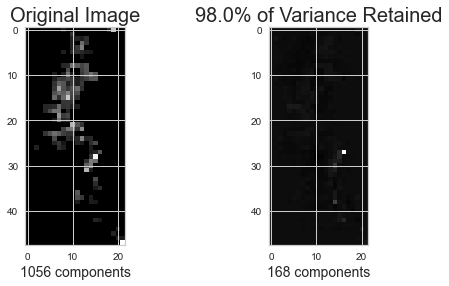

In [457]:
#image reconstruction using the less dimensioned data
plt.figure(figsize=(8,4));

n = 500 #index value, change to view different data

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(X[n].reshape(X_train.shape[1], X_train.shape[2]),
              cmap = plt.cm.gray,);
plt.xlabel(str(X.shape[1])+' components', fontsize = 14)
plt.title('Original Image', fontsize = 20);

# 196 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[n].reshape(X_train.shape[1], X_train.shape[2]),
              cmap = plt.cm.gray,);
plt.xlabel(str(Clus_dataSet.shape[1]) +' components', fontsize = 14)
plt.title(str(variance * 100) + '% of Variance Retained', fontsize = 20);



In [458]:
y_train = df_merged['label']
y = y_train

In [459]:
y.unique()

array([' Links', ' Rechts', ' Bauch', ' Rücken', ' Aufrecht'],
      dtype=object)

In [460]:
type(y.nunique())

int

KNN

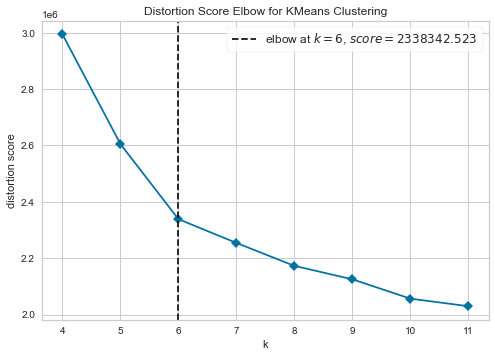

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [461]:
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(4,12), timings=False)
visualizer.fit(Clus_dataSet)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [462]:
check = visualizer.fit(Clus_dataSet)

In [463]:
check

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=11), k=(4, 12), timings=False)

In [464]:
# inertia = []
# for k in range(5, 100):
#     kmeans = KMeans(init = "k-means++",n_clusters=6, n_init = k,random_state=1).fit(Clus_dataSet)
#     inertia.append(np.sqrt(kmeans.inertia_))

# plt.plot(range(5, 100), inertia, marker='s');
# plt.xlabel('$k$')
# plt.ylabel('$J(C_k)$');

In [465]:
#n_clusters = 10 because INDEX has 10 values. Not the best value but a simple logic.
#The value of n_init at 35 yields good results so we will use it. For confirmation us the above code.
k_means = KMeans(init = "k-means++", n_clusters = y.nunique(), n_init = 30)

The list of labels of the clusters are [0 1 2 3 4]


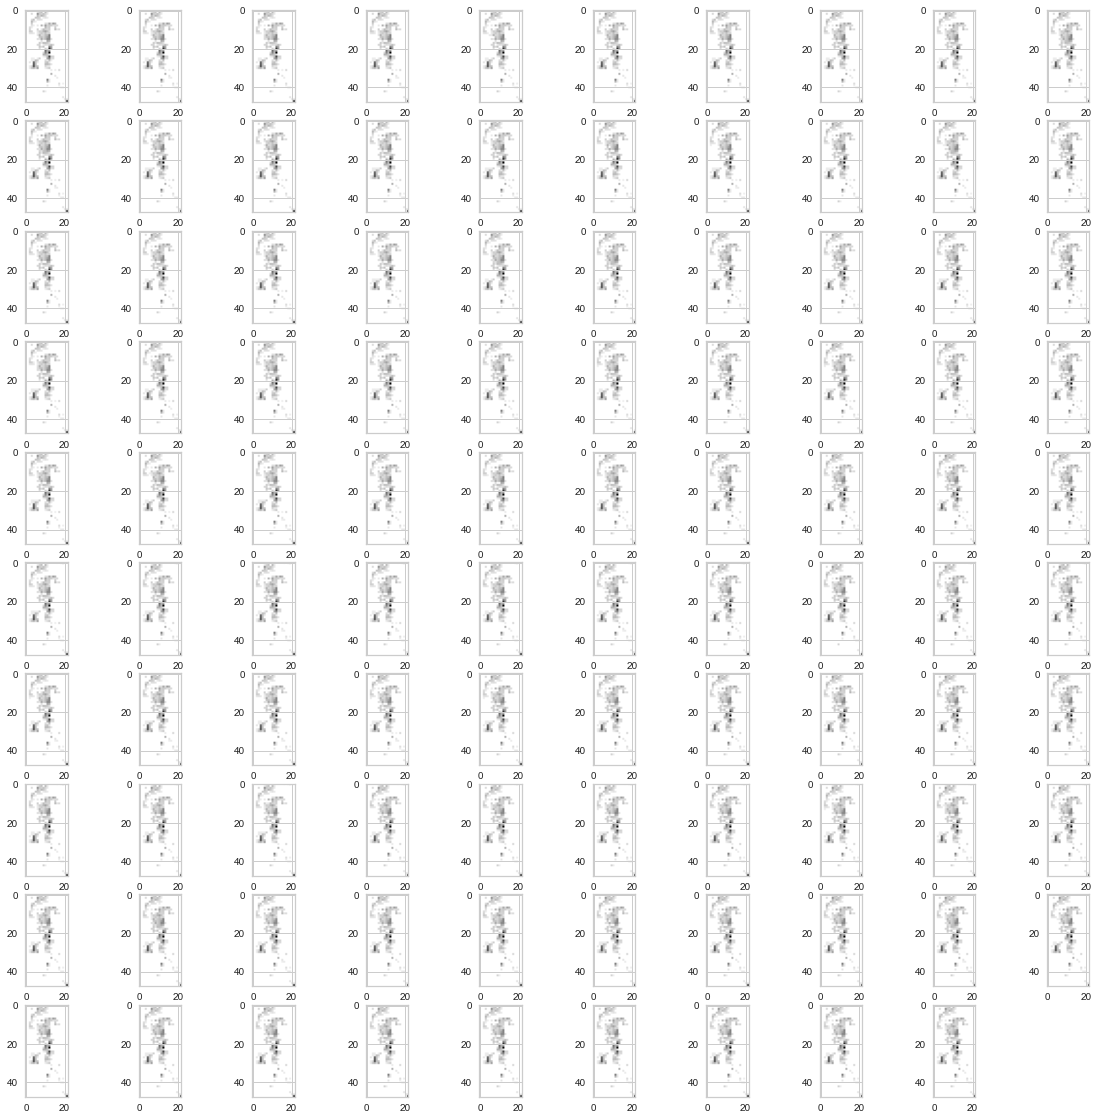

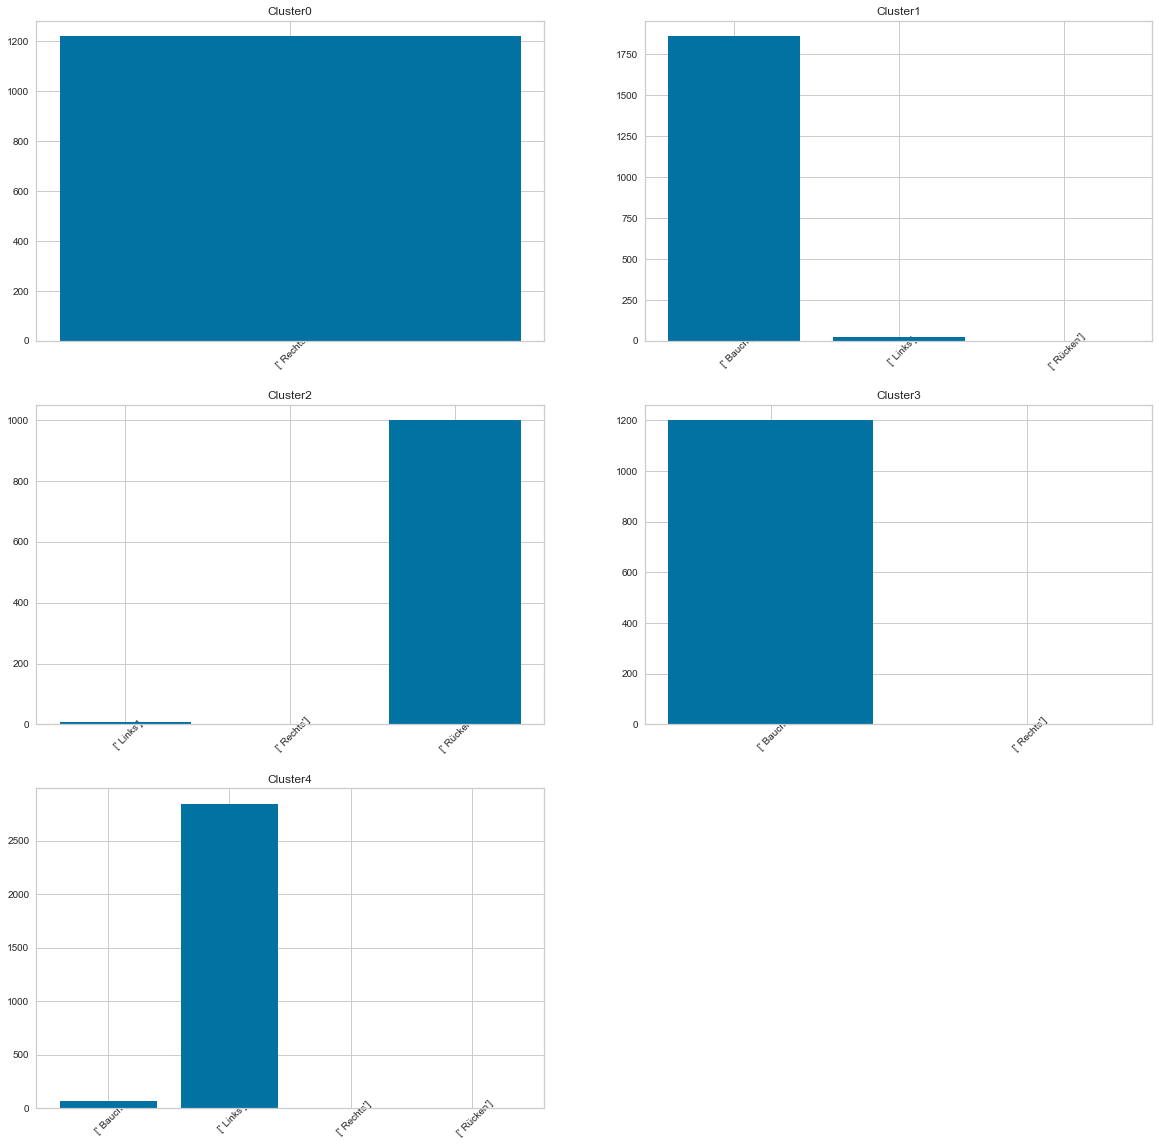

In [466]:
y_train = df_merged['label']
y = y_train
#n_clusters = number of unique value because INDEX has 10 values. Not the best value but a simple logic.
#The value of n_init at 30 yields good results so we will use it. For confirmation us the above code.
k_means = KMeans(init = "k-means++", n_clusters = y.nunique(), n_init = 30)
#fit the data to our k_means model
k_means.fit(Clus_dataSet)
#fit the data to our k_means model
k_means.fit(Clus_dataSet)

k_means_labels = k_means.labels_ #List of labels of each dataset
print("The list of labels of the clusters are " + str(np.unique(k_means_labels)))
G = len(np.unique(k_means_labels)) #Number of labels

#2D matrix  for an array of indexes of the given label
cluster_index= [[] for i in range(G)]
for i, label in enumerate(k_means_labels,0):
    for n in range(G):
        if label == n:
            cluster_index[n].append(i)
        else:
            continue   

#Visualisation for clusters = clust
plt.figure(figsize=(20,20));
clust = 3 #enter label number to visualise
num = 100 #num of data to visualize from the cluster
for i in range(1,num): 
    plt.subplot(10, 10, i); #(Number of rows, Number of column per row, item number)
    plt.imshow(X[cluster_index[clust][i+500]].reshape(X_train.shape[1], X_train.shape[2]), cmap = plt.cm.binary);
    
plt.show()

Y_clust = [[] for i in range(G)]
for n in range(G):
    Y_clust[n] = y[cluster_index[n]] #Y_clust[0] contains array of "correct" category from y_train for the cluster_index[0]
    assert(len(Y_clust[n]) == len(cluster_index[n])) #dimension confirmation

#counts the number of each category in each cluster
def counter(cluster):
    unique, counts = np.unique(cluster, return_counts=True)
    label_index = dict(zip(unique, counts))
    return label_index

label_count= [[] for i in range(G)]
for n in range(G):
    label_count[n] = counter(Y_clust[n])

label_count[1] #Number of items of a certain category in cluster 1
#A function to plot a bar graph for visualising the number of items of certain category in a cluster
def plotter(label_dict):
    plt.bar(range(len(label_dict)), list(label_dict.values()), align='center')
    a = []
    for i in [*label_dict]: a.append([i])
    plt.xticks(range(len(label_dict)), list(a), rotation=45, rotation_mode='anchor')
#Bar graph with the number of items of different categories clustered in it
plt.figure(figsize=(20,20))
for i in range (1,(y.nunique())+1):
    plt.subplot(3, 2, i)
    plotter(label_count[i-1]) 
    plt.title("Cluster" + str(i-1))


In [467]:
#fit the data to our k_means model
k_means.fit(Clus_dataSet)

KMeans(n_clusters=5, n_init=30)

In [416]:

k_means_labels = k_means.labels_ #List of labels of each dataset
print("The list of labels of the clusters are " + str(np.unique(k_means_labels)))

The list of labels of the clusters are [0 1 2 3 4]


In [417]:
G = len(np.unique(k_means_labels)) #Number of labels

#2D matrix  for an array of indexes of the given label
cluster_index= [[] for i in range(G)]
for i, label in enumerate(k_means_labels,0):
    for n in range(G):
        if label == n:
            cluster_index[n].append(i)
        else:
            continue   

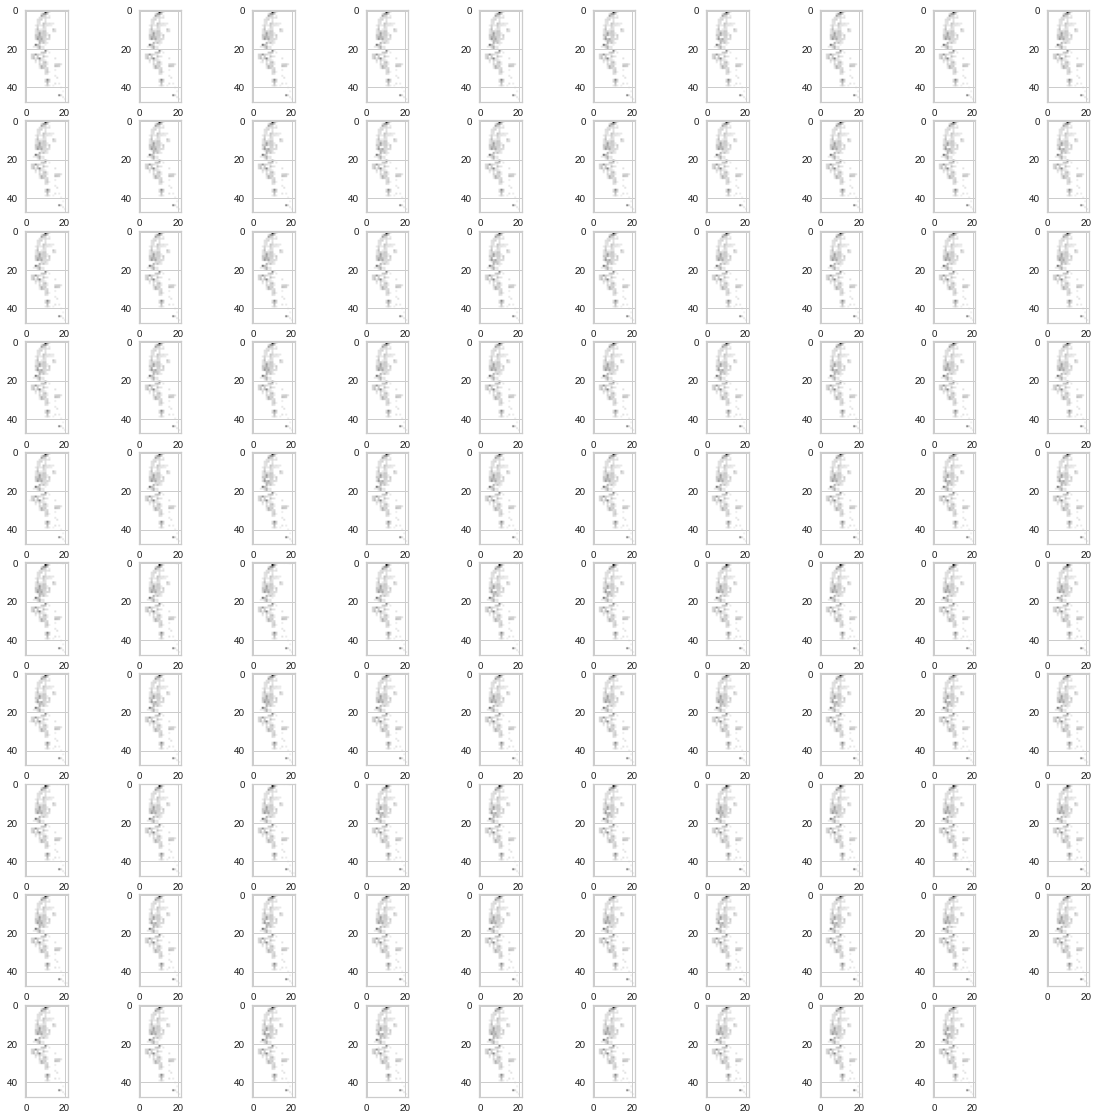

In [418]:
#Visualisation for clusters = clust
plt.figure(figsize=(20,20));
clust = 3 #enter label number to visualise
num = 100 #num of data to visualize from the cluster
for i in range(1,num): 
    plt.subplot(10, 10, i); #(Number of rows, Number of column per row, item number)
    plt.imshow(X[cluster_index[clust][i+500]].reshape(X_train.shape[1], X_train.shape[2]), cmap = plt.cm.binary);
    
plt.show()

In [ ]:
#counts the number of each category in each cluster
def counter(cluster):
    unique, counts = np.unique(cluster, return_counts=True)
    label_index = dict(zip(unique, counts))
    return label_index

label_count= [[] for i in range(G)]
for n in range(G):
    label_count[n] = counter(Y_clust[n])

label_count[1] #Number of items of a certain category in cluster 1
#A function to plot a bar graph for visualising the number of items of certain category in a cluster
def plotter(label_dict):
    plt.bar(range(len(label_dict)), list(label_dict.values()), align='center')
    a = []
    for i in [*label_dict]: a.append([i])
    plt.xticks(range(len(label_dict)), list(a), rotation=45, rotation_mode='anchor')
#Bar graph with the number of items of different categories clustered in it
plt.figure(figsize=(20,20))
for i in range (1,5):
    plt.subplot(3, 2, i)
    plotter(label_count[i-1]) 
    plt.title("Cluster" + str(i-1))

In [419]:
Y_clust = [[] for i in range(G)]
for n in range(G):
    Y_clust[n] = y[cluster_index[n]] #Y_clust[0] contains array of "correct" category from y_train for the cluster_index[0]
    assert(len(Y_clust[n]) == len(cluster_index[n])) #dimension confirmation

In [420]:
#counts the number of each category in each cluster
def counter(cluster):
    unique, counts = np.unique(cluster, return_counts=True)
    label_index = dict(zip(unique, counts))
    return label_index

In [421]:
label_count= [[] for i in range(G)]
for n in range(G):
    label_count[n] = counter(Y_clust[n])

label_count[1] #Number of items of a certain category in cluster 1

{' Bauch': 69, ' Links': 2847, ' Rechts': 4, ' Rücken': 2}

In [422]:
#A function to plot a bar graph for visualising the number of items of certain category in a cluster
def plotter(label_dict):
    plt.bar(range(len(label_dict)), list(label_dict.values()), align='center')
    a = []
    for i in [*label_dict]: a.append([i])
    plt.xticks(range(len(label_dict)), list(a), rotation=45, rotation_mode='anchor')

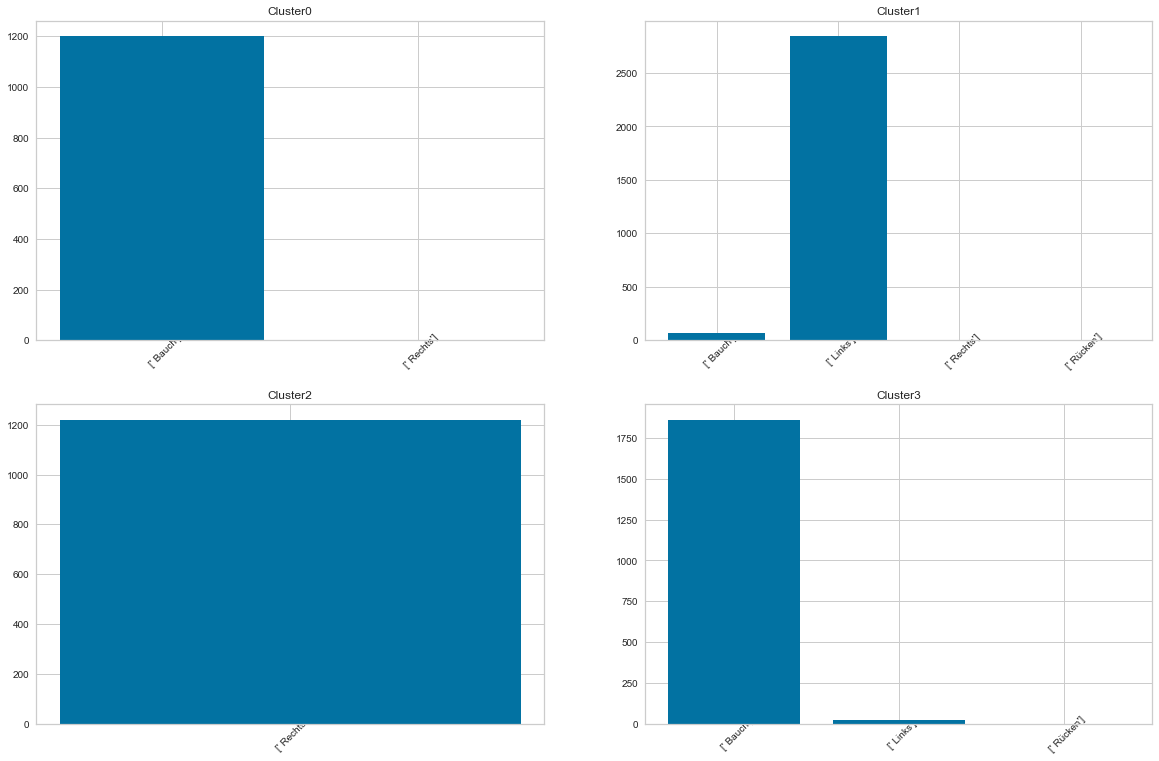

In [424]:
#Bar graph with the number of items of different categories clustered in it
plt.figure(figsize=(20,20))
for i in range (1,5):
    plt.subplot(3, 2, i)
    plotter(label_count[i-1]) 
    plt.title("Cluster" + str(i-1))

In [308]:
df_merged

,time,pressure,end,label
0,2022-03-25 00:59:33.945,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-03-25 00:59:34.547,Links
1,2022-03-25 00:59:34.547,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-03-25 00:59:35.149,Links
2,2022-03-25 00:59:35.149,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-03-25 00:59:35.750,Links
3,2022-03-25 00:59:35.750,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-03-25 00:59:36.352,Links
4,2022-03-25 00:59:36.352,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-03-25 00:59:36.754,Links
...,...,...,...,...
32318,2022-03-25 06:14:56.951,"[[0.0, 0.0, 0.0, 99.0, 0.0, 0.0, 0.0, 0.0, 0.0...",2022-03-25 06:14:57.452,Rechts
32319,2022-03-25 06:14:57.452,"[[0.0, 0.0, 0.0, 98.0, 0.0, 0.0, 0.0, 0.0, 0.0...",2022-03-25 06:14:58.054,Rechts
32320,2022-03-25 06:14:58.054,"[[0.0, 0.0, 0.0, 98.0, 0.0, 0.0, 0.0, 0.0, 0.0...",2022-03-25 06:14:58.656,Rechts
32321,2022-03-25 06:14:58.656,"[[0.0, 0.0, 0.0, 98.0, 0.0, 0.0, 0.0, 0.0, 0.0...",2022-03-25 06:14:59.265,Rechts


In [257]:
df_merged, df_end = get_label(txt[0],dt[0])

In [258]:
df_merged.head(5)

,time,pressure,end,label
0,2022-01-24 21:42:29.116,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 21:42:29.617,0
1,2022-01-24 21:42:29.617,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 21:42:30.119,0
2,2022-01-24 21:42:30.119,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 21:42:30.621,0
3,2022-01-24 21:42:30.621,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 21:42:59.425,0
4,2022-01-24 21:42:59.425,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 21:42:59.926,0


In [262]:
df_merged[df_merged['label']==0]

,time,pressure,end,label
0,2022-01-24 21:42:29.116,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 21:42:29.617,0
1,2022-01-24 21:42:29.617,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 21:42:30.119,0
2,2022-01-24 21:42:30.119,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 21:42:30.621,0
3,2022-01-24 21:42:30.621,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 21:42:59.425,0
4,2022-01-24 21:42:59.425,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 21:42:59.926,0
...,...,...,...,...
3040,2022-01-24 22:12:54.087,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 22:12:54.589,0
3041,2022-01-24 22:12:54.589,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 22:12:55.190,0
3042,2022-01-24 22:12:55.190,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 22:12:55.692,0
3043,2022-01-24 22:12:55.692,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 22:12:56.194,0


In [263]:
df_end

,time,Position,end
0,2022-01-24 22:12:56.500,Rücken,2022-01-24 22:23:01.250
1,2022-01-24 22:23:01.250,A,2022-01-24 22:23:04.000
2,2022-01-24 22:23:04.000,Rücken,2022-01-25 00:15:26.750
3,2022-01-25 00:15:26.750,Rechts,2022-01-25 00:52:49.500
4,2022-01-25 00:52:49.500,Rücken,2022-01-25 01:03:53.000
5,2022-01-25 01:03:53.000,Aufrecht,2022-01-25 01:07:43.750
6,2022-01-25 01:07:43.750,Bauch,2022-01-25 01:09:51.500
7,2022-01-25 01:09:51.500,Aufrecht,2022-01-25 01:11:54.250
8,2022-01-25 01:11:54.250,Bauch,2022-01-25 01:12:01.500
9,2022-01-25 01:12:01.500,Aufrecht,2022-01-25 01:17:35.750


In [265]:
df_merged.iloc[9999]

time                               2022-01-24 23:21:42.932000
pressure    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
end                                2022-01-24 23:21:43.333000
label                                                  Rücken
Name: 9999, dtype: object

In [177]:
df_merged[df_merged['label']==0]

,time,pressure,end,label


In [91]:
label = extract_label(txt[0])


In [92]:
label

,time,Position,end
0,2021-03-12 23:17:43.000,Rücken,2021-03-12 23:26:44.500
1,2021-03-12 23:26:44.500,A,2021-03-12 23:26:47.000
2,2021-03-12 23:26:47.000,Rücken,2021-03-12 23:30:28.241
3,2021-03-12 23:30:28.241,A,2021-03-12 23:30:30.750
4,2021-03-12 23:30:30.750,Rücken,2021-03-12 23:34:28.500
5,2021-03-12 23:34:28.500,Aufrecht,2021-03-12 23:36:36.500
6,2021-03-12 23:36:36.500,Rücken,2021-03-12 23:38:52.750
7,2021-03-12 23:38:52.750,Rechts,2021-03-12 23:39:04.750
8,2021-03-12 23:39:04.750,Bauch,2021-03-12 23:41:56.750
9,2021-03-12 23:41:56.750,Rücken,2021-03-12 23:43:08.241


In [99]:
data = get_data(dt[0])

In [95]:
data

,time,pressure,end,label
0,2021-12-03 23:46:25.221,"[[0.0, 0.0, 0.0, 0.0, 61.0, 0.0, 0.0, 0.0, 0.0...",2021-12-03 23:46:25.823,0
1,2021-12-03 23:46:25.823,"[[0.0, 0.0, 0.0, 0.0, 63.0, 0.0, 0.0, 0.0, 0.0...",2021-12-03 23:46:26.525,0
2,2021-12-03 23:46:26.525,"[[0.0, 0.0, 0.0, 0.0, 63.0, 0.0, 0.0, 0.0, 0.0...",2021-12-03 23:46:27.227,0
3,2021-12-03 23:46:27.227,"[[0.0, 0.0, 0.0, 0.0, 63.0, 0.0, 0.0, 0.0, 0.0...",2021-12-03 23:46:27.828,0
4,2021-12-03 23:46:27.828,"[[0.0, 0.0, 0.0, 0.0, 65.0, 0.0, 0.0, 0.0, 0.0...",2021-12-03 23:46:28.430,0
...,...,...,...,...
37251,2021-12-04 06:09:57.454,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2021-12-04 06:09:58.063,0
37252,2021-12-04 06:09:58.063,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2021-12-04 06:09:58.665,0
37253,2021-12-04 06:09:58.665,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2021-12-04 06:09:59.267,0
37254,2021-12-04 06:09:59.267,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2021-12-04 06:09:59.769,0


In [176]:
data = get_data(dt[8])
label = extract_label(txt[8])

In [267]:
label = extract_label(txt[0])

In [34]:
data = get_data(dt[3])

In [96]:
dx = get_data(dt[3])

In [97]:
dx

,time,pressure,end,label
0,2022-01-17 22:53:06.412,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-17 22:53:07.014,0
1,2022-01-17 22:53:07.014,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-17 22:53:07.616,0
2,2022-01-17 22:53:07.616,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-17 22:53:08.117,0
3,2022-01-17 22:53:08.117,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-17 22:53:08.719,0
4,2022-01-17 22:53:08.719,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-17 22:53:09.321,0
...,...,...,...,...
58751,2022-01-18 08:25:56.410,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-18 08:25:57.011,0
58752,2022-01-18 08:25:57.011,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-18 08:25:57.613,0
58753,2022-01-18 08:25:57.613,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-18 08:25:58.215,0
58754,2022-01-18 08:25:58.215,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-18 08:25:58.820,0


In [35]:
data

,time,pressure,end,label
0,2022-01-17 21:53:06.412,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-17 21:53:07.014,0
1,2022-01-17 21:53:07.014,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-17 21:53:07.616,0
2,2022-01-17 21:53:07.616,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-17 21:53:08.117,0
3,2022-01-17 21:53:08.117,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-17 21:53:08.719,0
4,2022-01-17 21:53:08.719,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-17 21:53:09.321,0
...,...,...,...,...
58751,2022-01-18 07:25:56.410,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-18 07:25:57.011,0
58752,2022-01-18 07:25:57.011,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-18 07:25:57.613,0
58753,2022-01-18 07:25:57.613,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-18 07:25:58.215,0
58754,2022-01-18 07:25:58.215,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-18 07:25:58.820,0


In [179]:
data.tail(5)

,time,pressure,end,label
35408,2022-03-19 04:29:57.367,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 0.0, 0.0...",2022-03-19 04:29:57.868,0
35409,2022-03-19 04:29:57.868,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 0.0, 0.0...",2022-03-19 04:29:58.370,0
35410,2022-03-19 04:29:58.370,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 0.0, 0.0...",2022-03-19 04:29:58.871,0
35411,2022-03-19 04:29:58.871,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 66.0, 0.0, 0.0...",2022-03-19 04:29:59.372,0
35412,2022-03-19 04:29:59.372,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 66.0, 0.0, 0.0...",2022-03-19 04:29:59.372,0


Here, you can see that pkl file start 1 hour later compare to label file

In [60]:
txt[9]

'c:\\Users\\phili\\techlabs\\eth_sms\\labels\\SMS_068_Körperlage.txt'

In [146]:
label[label['Position']==' Bauch']

,time,Position,end
36,2022-03-19 05:33:39,Bauch,2022-03-19 05:33:39


In [143]:
label.Position.unique()

array([' A', ' Rücken', ' Aufrecht', ' Rechts', ' Links', ' Bauch'],
      dtype=object)

In [183]:
df_merged.iloc[24786] #

time                               2022-03-19 02:43:17.322000
pressure    [[0.0, 0.0, 0.0, 0.0, 70.0, 0.0, 0.0, 0.0, 101...
end                                2022-03-19 02:43:17.924000
label                                                  Rechts
Name: 24786, dtype: object

Read EDF file

In [17]:
import mne

In [82]:
# https://stackoverflow.com/questions/51869713/how-to-read-edf-data-in-python-3
edf_fname = r'C:\Users\phili\techlabs\eth_sms\UNI85088612959895_(1).edf'
# edf_raw = mne.io.read_raw_edf(edf_fname, preload=True)
edf_raw = mne.io.read_raw_edf(edf_fname)
raw_data = edf_raw.get_data()
info = edf_raw.info
channels = edf_raw.ch_names



Extracting EDF parameters from C:\Users\phili\techlabs\eth_sms\UNI85088612959895_(1).edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [83]:
raw_data.shape

(45, 6728192)

In [86]:
raw_data[5]

array([1.        , 1.00225863, 1.00903045, ..., 6.        , 6.        ,
       6.        ])

Which channel of edf to export dataset like in pkl file?

In [20]:
len(edf_raw.ch_names)

45

Duplicate timestamp in pickle file

In [39]:
def get_rawdata(dt):
    data = pd.read_pickle(dt)
    data = data.reset_index()
    data = data.rename(columns={"index": "time", "matData": "pressure"})
    data['time'] = pd.to_datetime(data['time'],unit='ms')
    # df_new = data.drop_duplicates(subset='time', keep='first').reset_index().drop(columns= ['index']) #drop with exact date and hours and get the first one
    df_new = data
    df_new['end'] = df_new['time'].shift(-1) # get the duration
    df_new['end'] = np.where(df_new['end'].isnull(), df_new['time'], df_new['end'])
    df_new['label'] = 0
    return df_new

In [40]:
data = get_rawdata(dt[2])

In [41]:
data

,time,pressure,end,label
0,2022-01-19 23:59:44.891,"[[118.0, 0.0, 83.0, 182.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-19 23:59:44.891,0
1,2022-01-19 23:59:44.891,"[[117.0, 0.0, 82.0, 182.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-19 23:59:45.593,0
2,2022-01-19 23:59:45.593,"[[117.0, 0.0, 84.0, 182.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-19 23:59:45.593,0
3,2022-01-19 23:59:45.593,"[[116.0, 0.0, 83.0, 181.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-19 23:59:46.195,0
4,2022-01-19 23:59:46.195,"[[116.0, 0.0, 82.0, 182.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-19 23:59:46.195,0
...,...,...,...,...
47358,2022-01-20 04:29:57.443,"[[94.0, 0.0, 77.0, 134.0, 0.0, 0.0, 0.0, 0.0, ...",2022-01-20 04:29:58.145,0
47359,2022-01-20 04:29:58.145,"[[94.0, 0.0, 75.0, 134.0, 0.0, 0.0, 0.0, 0.0, ...",2022-01-20 04:29:58.145,0
47360,2022-01-20 04:29:58.145,"[[94.0, 0.0, 75.0, 135.0, 0.0, 0.0, 0.0, 0.0, ...",2022-01-20 04:29:58.847,0
47361,2022-01-20 04:29:58.847,"[[93.0, 0.0, 77.0, 133.0, 0.0, 0.0, 0.0, 0.0, ...",2022-01-20 04:29:58.847,0


In [46]:
(data['pressure'][0] == data['pressure'][1]).all() #check if pressure on 2022-01-19 23:59:44.891 for first entry and second entry exact the same

False

In [44]:
test

,time,pressure,end,label
0,2022-01-20 04:29:58.145,"[[94.0, 0.0, 75.0, 134.0, 0.0, 0.0, 0.0, 0.0, ...",2022-01-20 04:29:58.145,0
1,2022-01-20 04:29:58.145,"[[94.0, 0.0, 75.0, 135.0, 0.0, 0.0, 0.0, 0.0, ...",2022-01-20 04:29:58.847,0


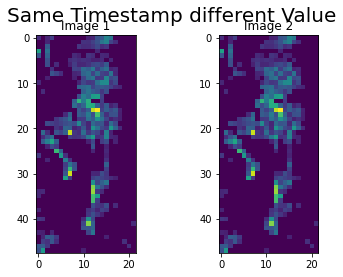

In [43]:
test = data[data['time'] == '2022-01-20 04:29:58.145'].reset_index().drop(columns=['index'])
fig, (ax1, ax2) = plt.subplots(1,2)

fig.suptitle('Same Timestamp different Value', fontsize=20)

# Line plots
ax1.set_title('Image 1')
ax1.imshow(test['pressure'][0])

ax2.set_title('Image 2')
ax2.imshow(test['pressure'][0])



In [77]:
df_merged.label.nunique()

4

Number of dataset vs duplicate timestamp

<AxesSubplot:>

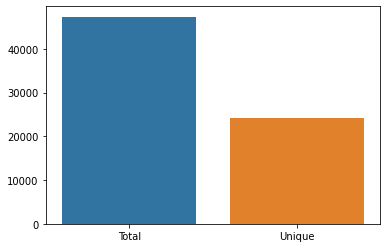

In [51]:
raw_data = {
    'x': ['Total','Unique'],
    'y': [len(data.time),  len(data.drop_duplicates(subset='time', keep='first'))]
           }

sns.barplot(x='x', y='y', data=raw_data)

Make Video

In [270]:
# import numpy as np
# import cv2
# size = 720*16//9, 720
# duration = 2
# fps = 25
# out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]), False)
# for _ in range(fps * duration):
#     data = np.random.randint(0, 256, size, dtype='uint8')
#     out.write(data)
# out.release()

In [61]:
df_merged, df_end = get_label(txt[9],dt[9])

In [62]:
img = []
lbl = []
for i in range(0, len(df_merged['pressure'])):
    img.append(df_merged['pressure'][i])
    lbl.append(df_merged['label'][i])


In [63]:
df_merged.label.unique()

array([' Links', ' Rechts', ' Bauch', ' Rücken', ' Aufrecht'],
      dtype=object)

In [64]:
df_merged[df_merged['label']==' Bauch'].head(100)

,time,pressure,end,label
4049,2022-03-17 23:00:24.835,"[[0.0, 0.0, 439.0, 0.0, 97.0, 0.0, 0.0, 0.0, 6...",2022-03-17 23:00:25.437,Bauch
4050,2022-03-17 23:00:25.437,"[[0.0, 0.0, 429.0, 0.0, 71.0, 0.0, 0.0, 0.0, 6...",2022-03-17 23:00:25.939,Bauch
4051,2022-03-17 23:00:25.939,"[[0.0, 0.0, 411.0, 0.0, 65.0, 0.0, 0.0, 0.0, 6...",2022-03-17 23:00:26.541,Bauch
4052,2022-03-17 23:00:26.541,"[[0.0, 0.0, 368.0, 0.0, 0.0, 0.0, 0.0, 0.0, 95...",2022-03-17 23:00:27.143,Bauch
4053,2022-03-17 23:00:27.143,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 89.0, 0.0, 133...",2022-03-17 23:00:27.745,Bauch
...,...,...,...,...
4144,2022-03-17 23:01:22.814,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 0.0, 161...",2022-03-17 23:01:23.422,Bauch
4145,2022-03-17 23:01:23.422,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 0.0, 162...",2022-03-17 23:01:24.024,Bauch
4146,2022-03-17 23:01:24.024,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 0.0, 161...",2022-03-17 23:01:24.726,Bauch
4147,2022-03-17 23:01:24.726,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 0.0, 162...",2022-03-17 23:01:25.428,Bauch


In [66]:
df_merged.tail(5)

,time,pressure,end,label
43828,2022-03-18 05:39:56.968,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 124.0, 77.0, 7...",2022-03-18 05:39:57.369,Bauch
43829,2022-03-18 05:39:57.369,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 123.0, 77.0, 7...",2022-03-18 05:39:57.971,Bauch
43830,2022-03-18 05:39:57.971,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 121.0, 76.0, 7...",2022-03-18 05:39:58.573,Bauch
43831,2022-03-18 05:39:58.573,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 121.0, 76.0, 7...",2022-03-18 05:39:59.175,Bauch
43832,2022-03-18 05:39:59.175,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 121.0, 75.0, 7...",2022-03-18 05:39:59.175,Bauch


In [65]:
df_end

,time,Position,end
0,2022-03-17 22:05:12.240,A,2022-03-17 22:05:12.241
1,2022-03-17 22:05:12.241,Rücken,2022-03-17 22:20:00.500
2,2022-03-17 22:20:00.500,Links,2022-03-17 22:47:55.000
3,2022-03-17 22:47:55.000,Rechts,2022-03-17 23:00:24.500
4,2022-03-17 23:00:24.500,Bauch,2022-03-17 23:33:04.250
5,2022-03-17 23:33:04.250,Links,2022-03-17 23:33:36.000
6,2022-03-17 23:33:36.000,Rücken,2022-03-18 00:44:17.500
7,2022-03-18 00:44:17.500,Links,2022-03-18 02:08:40.500
8,2022-03-18 02:08:40.500,Rücken,2022-03-18 02:58:14.000
9,2022-03-18 02:58:14.000,Aufrecht,2022-03-18 03:02:48.250


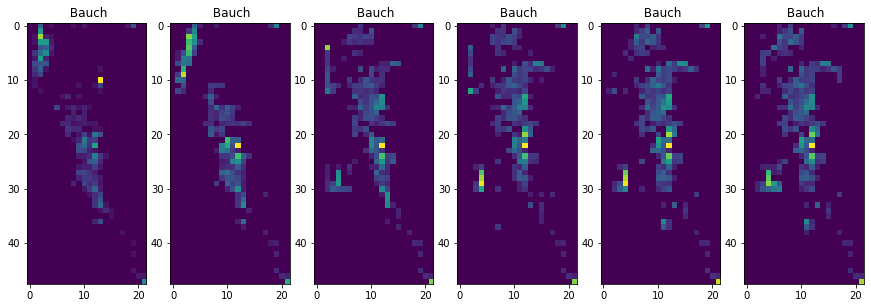

In [50]:
fig, axs = plt.subplots(1,6,figsize=(15, 6),)
for i in range(6):

    axs[i].set_title(df_merged['label'][i*10+4050])
    axs[i].imshow(df_merged['pressure'][i*10+4050])

In [69]:
df_merged[df_merged['label']==' Aufrecht']

,time,pressure,end,label
27322,2022-03-18 02:58:14.176,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 204....",2022-03-18 02:58:14.678,Aufrecht
27323,2022-03-18 02:58:14.678,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 205....",2022-03-18 02:58:15.280,Aufrecht
27324,2022-03-18 02:58:15.280,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 63.0, 0.0, 224...",2022-03-18 02:58:15.782,Aufrecht
27325,2022-03-18 02:58:15.782,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 104.0, 0.0, 23...",2022-03-18 02:58:16.384,Aufrecht
27326,2022-03-18 02:58:16.384,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 109....",2022-03-18 02:58:16.986,Aufrecht
...,...,...,...,...
27829,2022-03-18 03:02:45.825,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 135....",2022-03-18 03:02:46.427,Aufrecht
27830,2022-03-18 03:02:46.427,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 136....",2022-03-18 03:02:47.029,Aufrecht
27831,2022-03-18 03:02:47.029,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 135....",2022-03-18 03:02:47.531,Aufrecht
27832,2022-03-18 03:02:47.531,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 128....",2022-03-18 03:02:48.033,Aufrecht


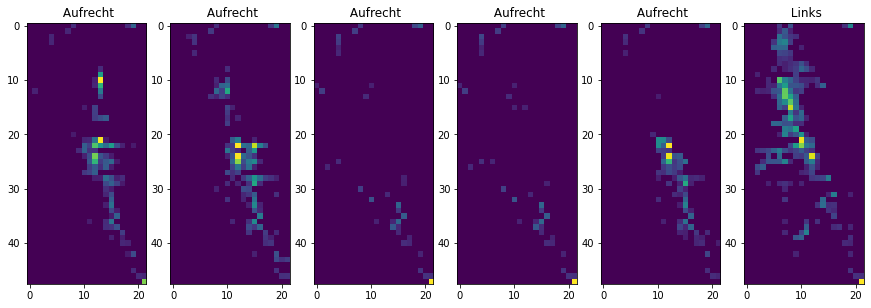

In [72]:
fig, axs = plt.subplots(1,6,figsize=(15, 6),)
for i in range(6):

    axs[i].set_title(df_merged['label'][i*125+27330])
    axs[i].imshow(df_merged['pressure'][i*125+27330])

In [22]:
import cv2
img2 = np.zeros( ( np.array(img).shape[0], np.array(img).shape[1], 3 ) )
img2[:,:,0] = img # same value in each channel
img2[:,:,1] = img
img2[:,:,2] = img
cv2.imshow('image',img2)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [194]:
# import cv2
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# img2 = np.zeros_like(img)
# img2[:,:,0] = gray
# img2[:,:,1] = gray
# img2[:,:,2] = gray

cv2.circle(img2, (10,10), 5, (255,255,0))
cv2.imshow("colour again", img2)
cv2.waitKey()

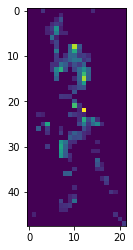

In [136]:
plt.imshow(df_merged['pressure'].iloc[-1])

In [281]:
merged_dir = os.getcwd()+'\video'
for tx, lb in zip(txt, dt):
    try:
        df_merged, df_end = get_label(tx,lb)
        img = []
        lbl = []
        for i in range(0, len(df_merged['pressure'])):
            img.append(df_merged['pressure'][i])
            lbl.append(df_merged['label'][i])

        size = img[0].shape
        fps = 100

        if tx[-10:-4]=='Events':
            # initialize video writer
            out = cv2.VideoWriter(f'video/{tx[-18:-4]}.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]),False)
        else:
            # initialize video writer
            out = cv2.VideoWriter(f'video/{tx[-22:-4]}.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]),False)
        # # initialize video writer
        # out = cv2.VideoWriter(f'video/{tx[-22:-4]}.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]),False)

        for im, lb in zip(img, lbl):
            im = im.astype(np.uint8)
            im = cv2.normalize(im, None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            im_3c = cv2.merge([im, im, im])
            out.write(im)
        out.release()
        
    except EOFError:
        print(f'no data for',tx[-22:-4])

In [68]:
# import numpy as np
# import cv2
# size = img[0].shape
# fps = 100

# # initialize video writer
# out = cv2.VideoWriter('output_%.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]),False)

# for im, lb in zip(img, lbl):
#     im = im.astype(np.uint8)
#     im = cv2.normalize(im, None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
#         """Return a sharpened version of the image, using an unsharp mask."""
#         blurred = cv2.GaussianBlur(image, kernel_size, sigma)
#         sharpened = float(amount + 1) * image - float(amount) * blurred
#         sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
#         sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
#         sharpened = sharpened.round().astype(np.uint8)
#         if threshold > 0:
#             low_contrast_mask = np.absolute(image - blurred) < threshold
#             np.copyto(sharpened, image, where=low_contrast_mask)
#         return sharpened
#     im = unsharp_mask(im)
#     im_3c = cv2.merge([im, im, im])
#     out.write(im)
# out.release()

In [ ]:
# import numpy as np
# import cv2
# size = img[0].shape
# fps = 100

# # initialize video writer
# # video_filename = 'nextoutput.avi'
# # fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
# # out = cv2.VideoWriter(video_filename, fourcc, fps, (size[1], size[0]),False)
# out = cv2.VideoWriter('output_%.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]),False)
# # for _ in range(fps * duration):
# # for im in img:
# for im, lb in zip(img, lbl):
#     # data = np.random.randint(0, 256, size, dtype='uint8')
#     # out.write(data)
#     im = im.astype(np.uint8)
#     im = cv2.normalize(im, None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     # # font
#     # font = cv2.FONT_HERSHEY_SIMPLEX
#     # # org
#     # org = (10, 10)
#     # # fontScale
#     # fontScale = 5
#     # # White color in BGR
#     # color = (255,255,255)
#     # # Line thickness of 2 px
#     # thickness = 2
#     # # Using cv2.putText() method
#     # # im = cv2.putText(im, lb, org, font, 
#     #                 # fontScale, color, thickness)
#     # font = cv2.FONT_HERSHEY_SIMPLEX
#     # im = cv2.putText(frame, 
#     #             'LSS', 
#     #             (10, 10), 
#     #             font, 1, 
#     #             (0), 
#     #             1, 
#     #             cv2.LINE_4)
#     # # im = cv2.medianBlur(im, 5)
#     # im = cv2.normalize(im, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     im_3c = cv2.merge([im, im, im])
#     out.write(im)
# out.release()

In [168]:
# import numpy as np
# import cv2
# size = img[0].shape
# fps = 100

# # initialize video writer
# # video_filename = 'nextoutput.avi'
# # fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
# # out = cv2.VideoWriter(video_filename, fourcc, fps, (size[1], size[0]),False)
# out = cv2.VideoWriter('output_%.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]),False)
# # for _ in range(fps * duration):
# # for im in img:
# for im, lb in zip(img, lbl):
#     # data = np.random.randint(0, 256, size, dtype='uint8')
#     # out.write(data)
#     im = im.astype(np.uint8)
#     im = cv2.normalize(im, None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     # # font
#     # font = cv2.FONT_HERSHEY_SIMPLEX
#     # # org
#     # org = (10, 10)
#     # # fontScale
#     # fontScale = 5
#     # # White color in BGR
#     # color = (255,255,255)
#     # # Line thickness of 2 px
#     # thickness = 2
#     # # Using cv2.putText() method
#     # # im = cv2.putText(im, lb, org, font, 
#     #                 # fontScale, color, thickness)
#     # font = cv2.FONT_HERSHEY_SIMPLEX
#     # im = cv2.putText(frame, 
#     #             'LSS', 
#     #             (10, 10), 
#     #             font, 1, 
#     #             (0), 
#     #             1, 
#     #             cv2.LINE_4)
d
#     # im = cv2.normalize(im, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     im_3c = cv2.merge([im, im, im])
#     out.write(im)
# out.release()